In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.naive_bayes import GaussianNB
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, precision_score, recall_score, f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

from feature_engine import encoding as ce
from feature_engine import imputation as mdi
from feature_engine import discretisation as dsc

### Функции

In [31]:
def plot_all_numeric_histplot(data, bins = 30):
    """
    Строит гистограммы с KDE для всех числовых признаков, кроме 'SalePrice'.
    
    """
    numeric_cols = data.select_dtypes(include = 'number').columns
    numeric_cols = [col for col in numeric_cols if col.lower() != 'Saleprice']

    for col in numeric_cols:
        plt.figure(figsize = (8, 4))
        sns.histplot(data[col].dropna(), bins = bins, kde = True)
        plt.title(f'Распределение {col}')
        plt.xlabel(col)
        plt.ylabel('Частота')
        plt.tight_layout()
        plt.show()

In [36]:
def plot_categorical_boxplot(data, target = 'SalePrice'):
    """
    Строит boxplot'ы зависимости целевой переменной от всех категориальных признаков в датафрейме.
    """
    categorical_cols = data.select_dtypes(include = 'object').columns

    for col in categorical_cols:
        if target not in data.columns:
            continue
        order = data[col].value_counts().index
        plt.figure(figsize = (10, 5))
        sns.boxplot(x = col, y = target, data = data, order = order)
        plt.title(f'{target} в зависимости от {col}')
        plt.xlabel(col)
        plt.ylabel(target)
        plt.xticks(rotation = 45)
        plt.tight_layout()
        plt.show()

In [33]:
def numeric_correlations(data):
    """
    Возвращает Series с корреляциями всех числовых признаков с SalePrice, отсортированную по убыванию.
    
    """
    numeric_df = data.select_dtypes(include = 'number')
    if 'SalePrice' not in numeric_df.columns:
        raise ValueError("В датафрейме нет колонки 'SalePrice'.")

    correlations = numeric_df.corr()['SalePrice'].drop('SalePrice')
    return correlations.sort_values(ascending = False).round(3)

In [4]:
data = pd.read_csv("../houseprice.csv")
data.shape

(1460, 81)

In [5]:
data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


Общая информация о доме

| Признак        | Значение                                                |
| -------------- | ------------------------------------------------------- |
| `Id`           | Уникальный идентификатор дома                           |
| `MSSubClass`   | Класс здания (по назначению) — числовой код типа жилища |
| `MSZoning`     | Зонирование (жилое, промышленное и т.п.)                |
| `LotFrontage`  | Ширина участка, примыкающего к улице (в футах)          |
| `LotArea`      | Площадь участка (в квадратных футах)                    |
| `Street`       | Тип дороги (асфальт, гравий)                            |
| `Alley`        | Тип переулка (если есть)                                |
| `LotShape`     | Форма участка (регулярный, трапеция и т.п.)             |
| `LandContour`  | Контур участка (ровный, скат и т.п.)                    |
| `Utilities`    | Коммуникации (вода, электричество)                      |
| `LotConfig`    | Конфигурация участка (угловой, внутри квартала и т.д.)  |
| `LandSlope`    | Уклон участка                                           |
| `Neighborhood` | Район (название)                                        |
| `Condition1/2` | Прилегающие объекты (дороги, железные дороги и пр.)     |

Тип дома и его конструкция

| Признак        | Значение                                         |
| -------------- | ------------------------------------------------ |
| `BldgType`     | Тип здания (отдельный дом, таунхаус и т.п.)      |
| `HouseStyle`   | Этажность/тип дома (1-этажный, 2-этажный и т.п.) |
| `OverallQual`  | Общая оценка качества (1–10)                     |
| `OverallCond`  | Общая оценка состояния (1–10)                    |
| `YearBuilt`    | Год постройки                                    |
| `YearRemodAdd` | Год последнего ремонта или реконструкции         |

Внешний вид и материалы

| Признак           | Значение                              |
| ----------------- | ------------------------------------- |
| `RoofStyle`       | Тип крыши                             |
| `RoofMatl`        | Материал крыши                        |
| `Exterior1st/2nd` | Наружная отделка (1-я и 2-я)          |
| `MasVnrType`      | Тип каменной/кирпичной отделки фасада |
| `MasVnrArea`      | Площадь этой отделки                  |
| `ExterQual`       | Качество внешней отделки              |
| `ExterCond`       | Состояние внешней отделки             |

Фундамент и подвал

| Признак          | Значение                                        |
| ---------------- | ----------------------------------------------- |
| `Foundation`     | Тип фундамента                                  |
| `BsmtQual`       | Качество подвала                                |
| `BsmtCond`       | Состояние подвала                               |
| `BsmtExposure`   | Наличие окон в подвале                          |
| `BsmtFinType1/2` | Тип отделки подвала (основной и дополнительный) |
| `BsmtFinSF1/2`   | Площадь отделанного подвала                     |
| `BsmtUnfSF`      | Площадь неотделанного подвала                   |
| `TotalBsmtSF`    | Общая площадь подвала                           |

Отопление и электроника

| Признак      | Значение                            |
| ------------ | ----------------------------------- |
| `Heating`    | Тип отопления                       |
| `HeatingQC`  | Качество системы отопления          |
| `CentralAir` | Центральное кондиционирование (Y/N) |
| `Electrical` | Тип электропроводки                 |

Жилая площадь и комнаты

| Признак                 | Значение                          |
| ----------------------- | --------------------------------- |
| `1stFlrSF/2ndFlrSF`     | Площадь 1-го и 2-го этажей        |
| `LowQualFinSF`          | Площадь низкокачественной отделки |
| `GrLivArea`             | Общая жилая площадь               |
| `BsmtFullBath/HalfBath` | Ванные комнаты в подвале          |
| `FullBath/HalfBath`     | Ванные комнаты выше уровня земли  |
| `BedroomAbvGr`          | Количество спален над землёй      |
| `KitchenAbvGr`          | Количество кухонь                 |
| `KitchenQual`           | Качество кухни                    |
| `TotRmsAbvGrd`          | Общее число комнат над землёй     |

Камины и функциональность

| Признак       | Значение                                                       |
| ------------- | -------------------------------------------------------------- |
| `Functional`  | Функциональность дома (нормально, минимальные проблемы и т.п.) |
| `Fireplaces`  | Количество каминов                                             |
| `FireplaceQu` | Качество камина                                                |

Гараж

| Признак        | Значение                                     |
| -------------- | -------------------------------------------- |
| `GarageType`   | Тип гаража (встроенный, пристроенный и т.п.) |
| `GarageYrBlt`  | Год постройки гаража                         |
| `GarageFinish` | Отделка внутренней части гаража              |
| `GarageCars`   | Количество машин, вмещающихся в гараж        |
| `GarageArea`   | Площадь гаража                               |
| `GarageQual`   | Качество гаража                              |
| `GarageCond`   | Состояние гаража                             |

Дополнительно

| Признак         | Значение                                  |
| --------------- | ----------------------------------------- |
| `PavedDrive`    | Асфальтирован ли подъезд                  |
| `WoodDeckSF`    | Площадь деревянной террасы                |
| `OpenPorchSF`   | Открытая веранда                          |
| `EnclosedPorch` | Закрытая веранда                          |
| `3SsnPorch`     | Трёхсезонная веранда                      |
| `ScreenPorch`   | Веранда с сеткой                          |
| `PoolArea`      | Площадь бассейна                          |
| `PoolQC`        | Качество бассейна                         |
| `Fence`         | Тип забора                                |
| `MiscFeature`   | Прочие особенности (теннис, сарай и т.п.) |
| `MiscVal`       | Стоимость прочих особенностей             |

Продажа

| Признак         | Значение                                     |
| --------------- | -------------------------------------------- |
| `MoSold`        | Месяц продажи                                |
| `YrSold`        | Год продажи                                  |
| `SaleType`      | Тип продажи (обычная, на аукционе и т.п.)    |
| `SaleCondition` | Условия продажи (обычная, наследство и т.п.) |
| `SalePrice`     | **Целевая переменная — цена продажи**        |

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [7]:
data.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


### Проверка пустых значений

In [8]:
null_stats = pd.DataFrame(data.isnull().sum(), columns=['missing_value_count'])
null_stats.loc[:,'% of dataset'] = np.round(null_stats.loc[:,'missing_value_count'] / data.shape[0] * 100, 2)
null_stats.loc[null_stats.loc[:,'missing_value_count']>0,:].sort_values(by='missing_value_count', ascending=False)

,missing_value_count,% of dataset
PoolQC,1453,99.52
MiscFeature,1406,96.30
Alley,1369,93.77
Fence,1179,80.75
MasVnrType,872,59.73
FireplaceQu,690,47.26
LotFrontage,259,17.74
GarageType,81,5.55
GarageYrBlt,81,5.55
GarageFinish,81,5.55


- `PoolQC`: 99.52% → столбец удалить, т.к. почти все значения отсутствуют.
- `MiscFeature`: 96.30% → можно удалить, т.к. почти все значения отсутствуют.
- `Alley`: 93.77% → можно удалить, т.к. почти все значения отсутствуют.
- `Fence`: 80.75% → тоже можно удалить из-за большого кол-ва пустых значенийю.
- `FireplaceQu`: 47.26%.
- `LotFrontage`: 17.74%.
- Признаки гаража (`GarageType` , `GarageYrBlt` , `GarageFinish` , `GarageQual` , `GarageCond`):
   5.55% каждый.
- Признаки подвала (`BsmtExposure` , `BsmtFinType1/2` , `BsmtQual` , `BsmtCond`):
   примерно 2.5–2.6%.
- `MasVnrType` и `MasVnrArea` : 0.55%.
- `Electrical` : 0.07%.

### Удаление переменных у которых пустых значений больше 60%

In [9]:
missing = data.isnull().mean()
high_missing = missing[missing > 0.6].index.tolist()
print(f"Удалены переменные с >60% пропусков: {high_missing}")
data.drop(columns = high_missing, inplace = True)
print("Новая форма после удаления:", data.shape)

Удалены переменные с >60% пропусков: ['Alley', 'PoolQC', 'Fence', 'MiscFeature']
Новая форма после удаления: (1460, 77)


### Проверка на наличие дубликатов

In [10]:
duplicate_count = data.duplicated().sum()
print(f"\nКоличество дубликатов в данных: {duplicate_count}")


Количество дубликатов в данных: 0


### Constant Variables

In [11]:
constant_cols = [col for col in data.columns 
                 if data[col].nunique() == 1]
print("Константные признаки:", constant_cols)

Константные признаки: []


### Find and remove Quasi-constant variables

In [12]:
threshold = 0.99
quasi_constant_cols = []

for col in data.columns:
    if data[col].nunique() > 1:
        top_freq = data[col].value_counts(normalize = True).iloc[0]
        if top_freq > threshold:
            quasi_constant_cols.append(col)

n_quasi = len(quasi_constant_cols)
print(f"Найдено квoзиконстантных переменных (> {threshold*100:.0f}% одного уровня): {n_quasi}")
print(f"Список удалённых переменных: {quasi_constant_cols}")

data.drop(columns = quasi_constant_cols, inplace = True)

print(f"Удалено квoзиконстантных переменных: {n_quasi}")
print("Новая форма датасета:", data.shape)

Найдено квoзиконстантных переменных (> 99% одного уровня): 3
Список удалённых переменных: ['Street', 'Utilities', 'PoolArea']
Удалено квoзиконстантных переменных: 3
Новая форма датасета: (1460, 74)


### Числовые переменные

In [13]:
num_cols = data.select_dtypes(include=[np.number]).columns.drop('SalePrice')
print(f"Числовые переменные: {len(num_cols)}")

Числовые переменные: 36


### Категориальные переменные

In [14]:
cat_cols = data.select_dtypes(include=['object']).columns.tolist()
print(f"Категориальные переменные: {len(cat_cols)}")

Категориальные переменные: 37


# EDA

### Распределение SalePrice

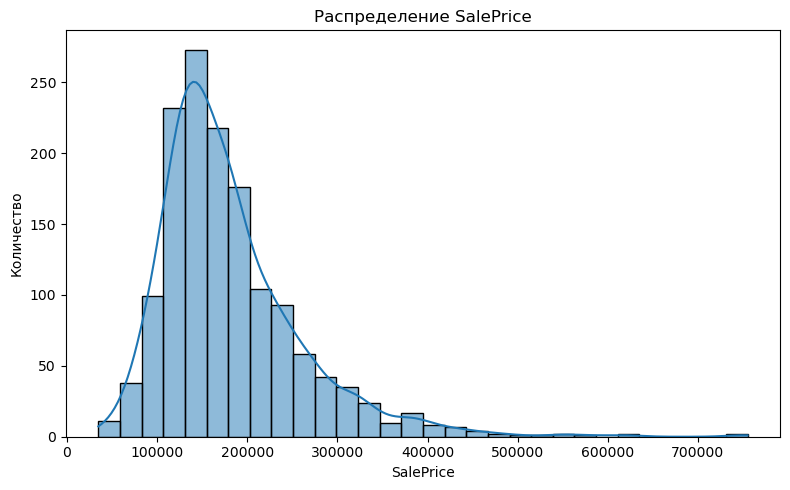

In [15]:
plt.figure(figsize = (8, 5))
sns.histplot(data['SalePrice'], bins = 30, kde = True)
plt.title('Распределение SalePrice')
plt.xlabel('SalePrice')
plt.ylabel('Количество')
plt.tight_layout()
plt.show()

- Распределение слегка скошенное

### Корреляция с SalePrice

In [16]:
corr_with_target = data.corr(numeric_only = True)['SalePrice'].sort_values(ascending = False)
corr_with_target

SalePrice        1.000000
OverallQual      0.790982
GrLivArea        0.708624
GarageCars       0.640409
GarageArea       0.623431
TotalBsmtSF      0.613581
1stFlrSF         0.605852
FullBath         0.560664
TotRmsAbvGrd     0.533723
YearBuilt        0.522897
YearRemodAdd     0.507101
GarageYrBlt      0.486362
MasVnrArea       0.477493
Fireplaces       0.466929
BsmtFinSF1       0.386420
LotFrontage      0.351799
WoodDeckSF       0.324413
2ndFlrSF         0.319334
OpenPorchSF      0.315856
HalfBath         0.284108
LotArea          0.263843
BsmtFullBath     0.227122
BsmtUnfSF        0.214479
BedroomAbvGr     0.168213
ScreenPorch      0.111447
MoSold           0.046432
3SsnPorch        0.044584
BsmtFinSF2      -0.011378
BsmtHalfBath    -0.016844
MiscVal         -0.021190
Id              -0.021917
LowQualFinSF    -0.025606
YrSold          -0.028923
OverallCond     -0.077856
MSSubClass      -0.084284
EnclosedPorch   -0.128578
KitchenAbvGr    -0.135907
Name: SalePrice, dtype: float64

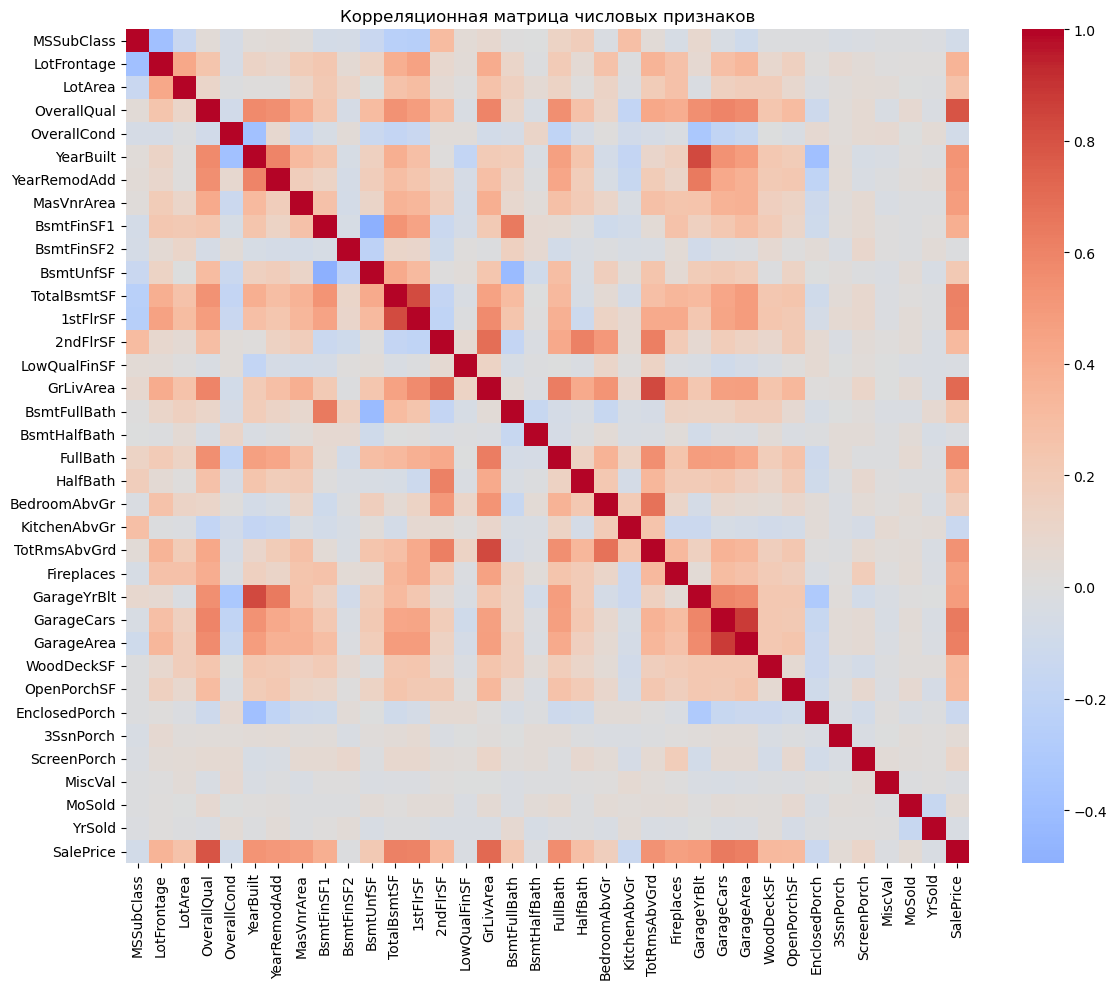

In [17]:
num_cols = data.select_dtypes(include='number').drop(columns=['Id'])
corr = num_cols.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(corr, cmap='coolwarm', center=0, fmt=".2f", annot=False)
plt.title('Корреляционная матрица числовых признаков')
plt.tight_layout()

# Анализ переменных по группам.

In [18]:
set1 = data[[
    'SalePrice', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea',
    'LotShape', 'LandContour', 'LotConfig', 'LandSlope',
    'Neighborhood', 'Condition1', 'Condition2'
]]

set2 = data[[
    'BldgType', 'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'SalePrice'
]]

set3 = data[[
    'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd',
    'MasVnrType', 'MasVnrArea', 'ExterQual', 'ExterCond', 'SalePrice'
]]

set4 = data[[
    'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
    'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'SalePrice'
]]

set5 = data[['Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'SalePrice']]

set6 = data[[
    '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea',
    'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
    'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd', 'SalePrice'
]]

set7 = data[['Functional', 'Fireplaces', 'FireplaceQu', 'SalePrice']]

set8 = data[[
    'GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageCars',
    'GarageArea', 'GarageQual', 'GarageCond', 'SalePrice'
]]

set9 = data[[
    'PavedDrive', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch',
    '3SsnPorch', 'ScreenPorch', 'MiscVal', 'SalePrice'
]]

set10 = data[['MoSold', 'YrSold', 'SaleType', 'SaleCondition', 'SalePrice']]

### Set1: Общая информация о доме

In [25]:
set1.head()

,SalePrice,MSSubClass,MSZoning,LotFrontage,LotArea,LotShape,LandContour,LotConfig,LandSlope,Neighborhood,Condition1,Condition2
0,208500,60,RL,65.0,8450,Reg,Lvl,Inside,Gtl,CollgCr,Norm,Norm
1,181500,20,RL,80.0,9600,Reg,Lvl,FR2,Gtl,Veenker,Feedr,Norm
2,223500,60,RL,68.0,11250,IR1,Lvl,Inside,Gtl,CollgCr,Norm,Norm
3,140000,70,RL,60.0,9550,IR1,Lvl,Corner,Gtl,Crawfor,Norm,Norm
4,250000,60,RL,84.0,14260,IR1,Lvl,FR2,Gtl,NoRidge,Norm,Norm


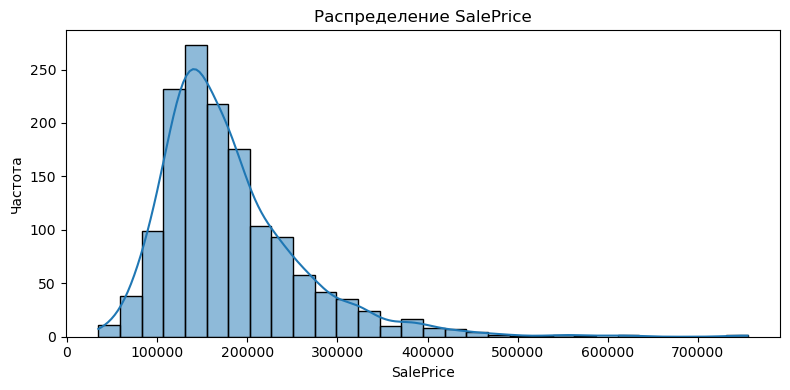

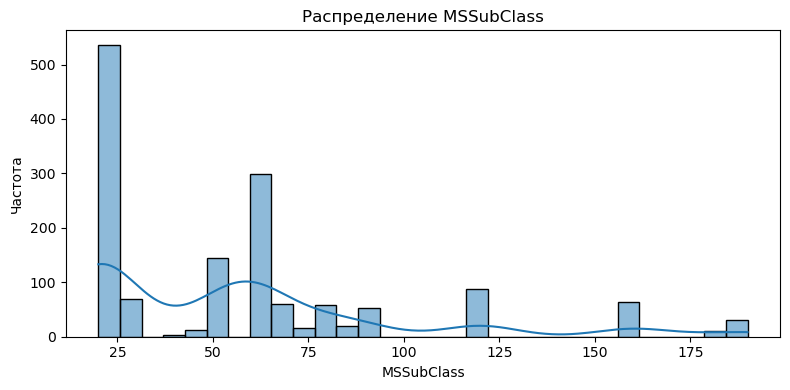

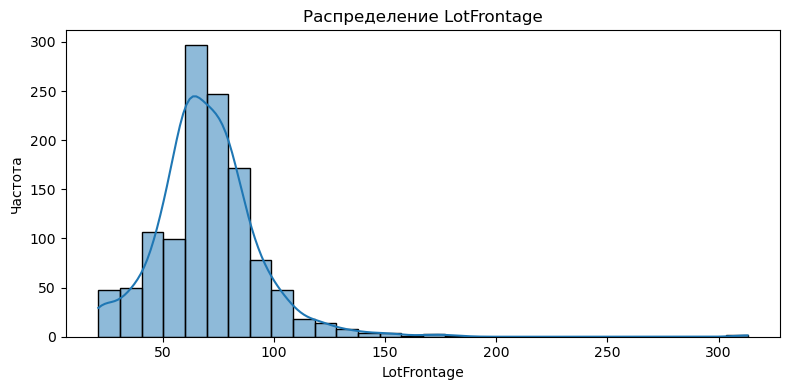

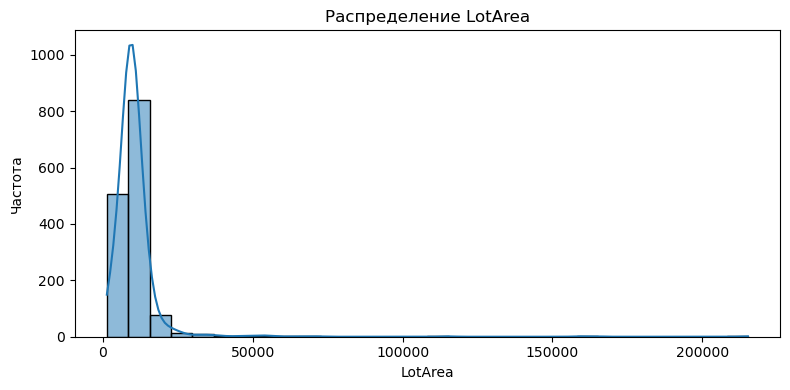

In [29]:
plot_all_numeric_histplot(set1)

- LotFrontage — примерно нормальное распределение, но с пропущенными значениями.

- MSSubClass — дискретное распределение.

In [34]:
numeric_correlations(set1)

LotFrontage    0.352
LotArea        0.264
MSSubClass    -0.084
Name: SalePrice, dtype: float64

- `LotFrontage` и `LotArea` слабо, но положительно коррелируют с ценой — чем шире и больше участок, тем выше цена.

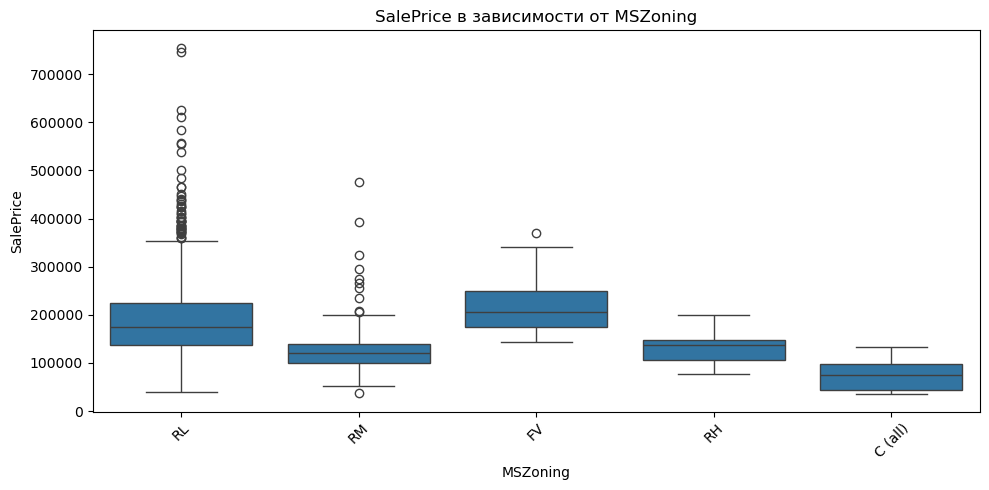

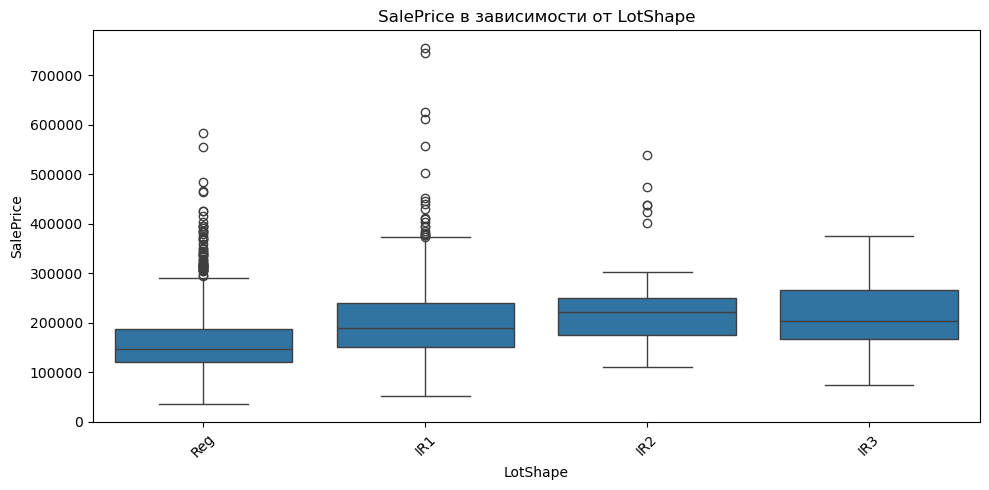

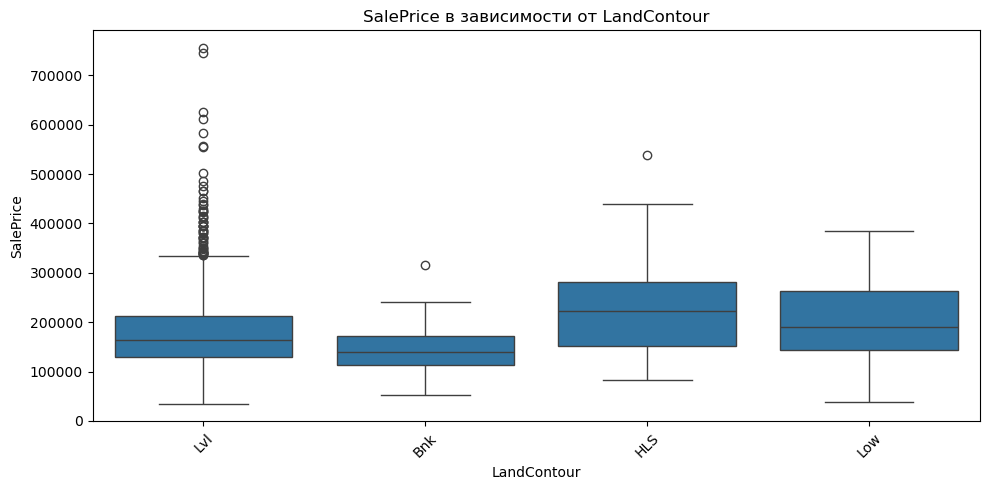

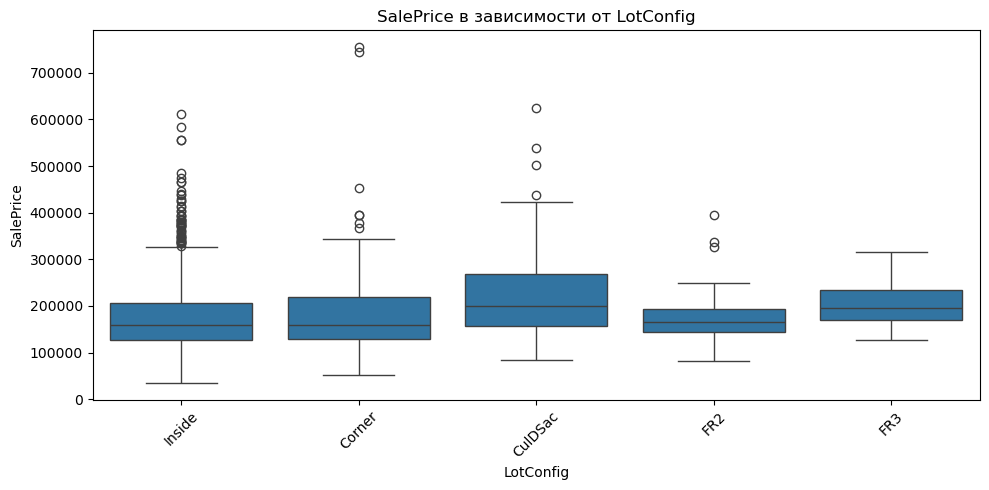

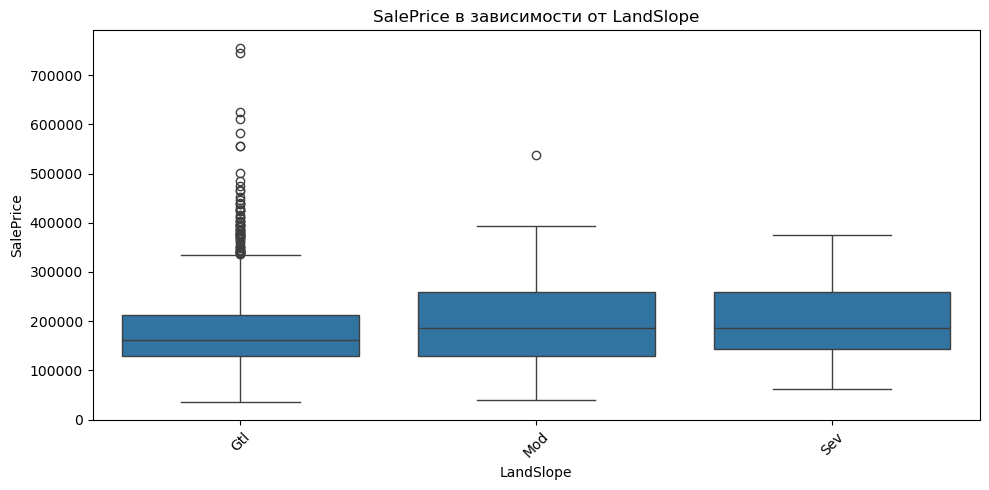

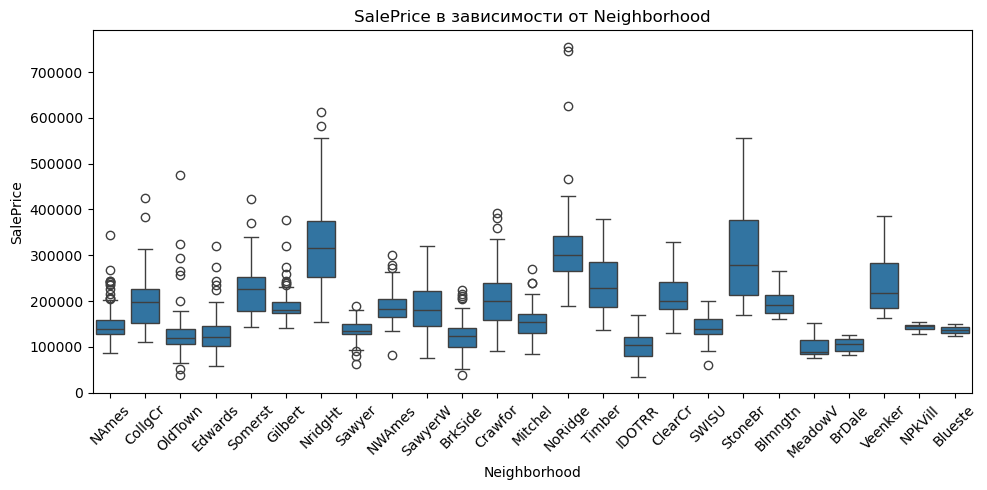

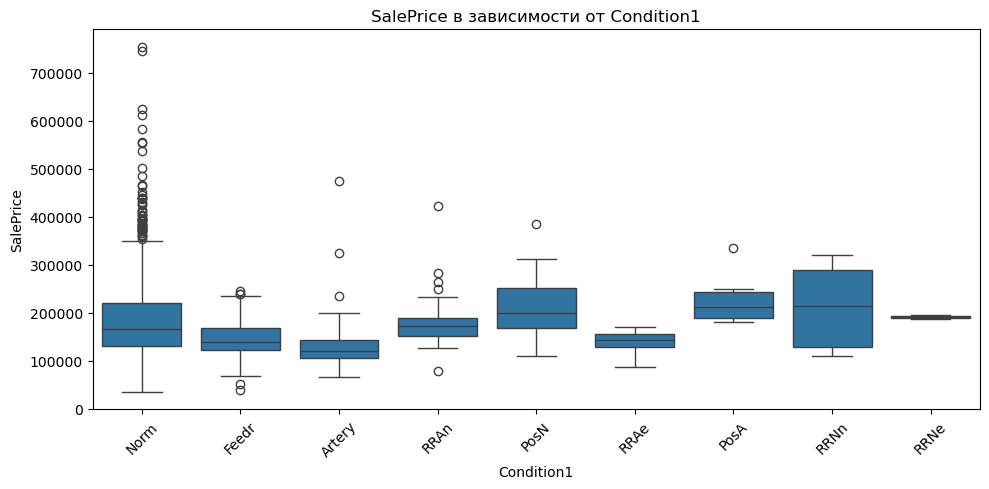

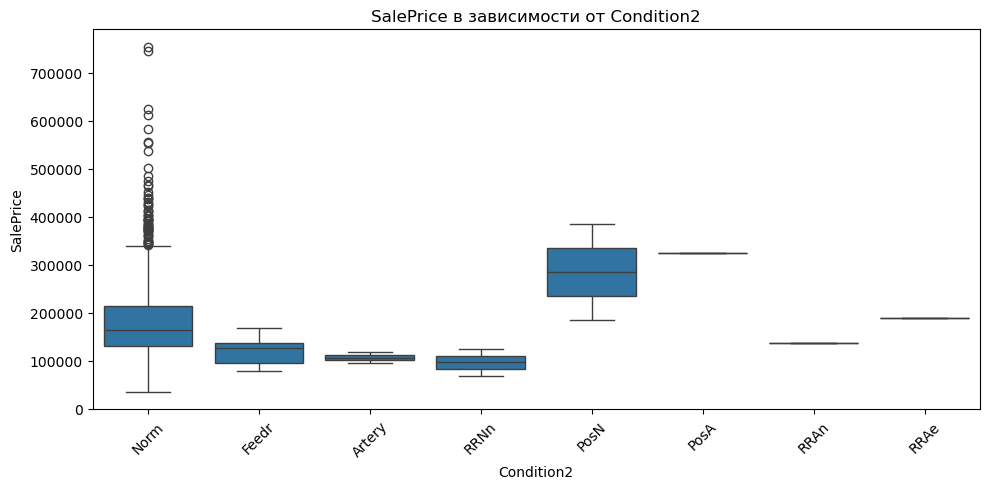

In [37]:
plot_categorical_boxplot(set1)

- Во многих категориях — особенно Neighborhood, MSZoning и LotConfig — наблюдаются выбросы вверх, то есть дома с ценой значительно выше основной массы.

- В одних и тех же условиях (участок, зона, район) могут быть как дешёвые, так и очень дорогие дома.

- Район (Neighborhood) — главный фактор, где дорогие дома формируют сильные выбросы. Такие выбросы важно учесть при моделировании, чтобы модель не переобучалась на них.

### Set2: Тип дома и его конструкция

In [39]:
numeric_correlations(set2)

OverallQual     0.791
YearBuilt       0.523
YearRemodAdd    0.507
OverallCond    -0.078
Name: SalePrice, dtype: float64

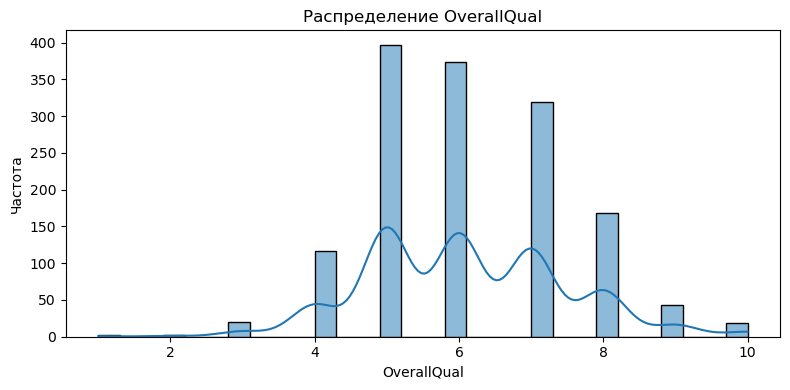

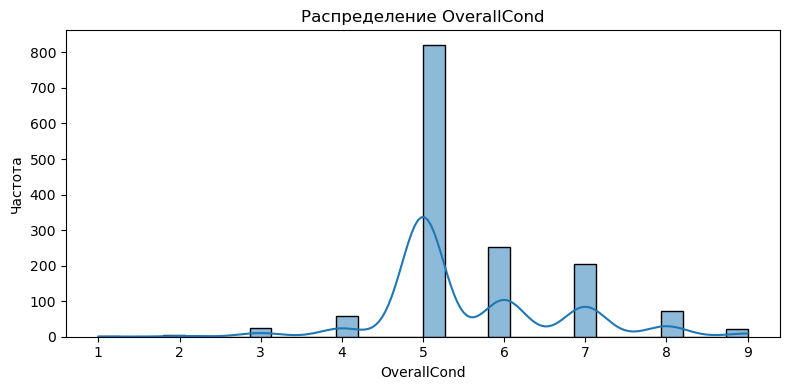

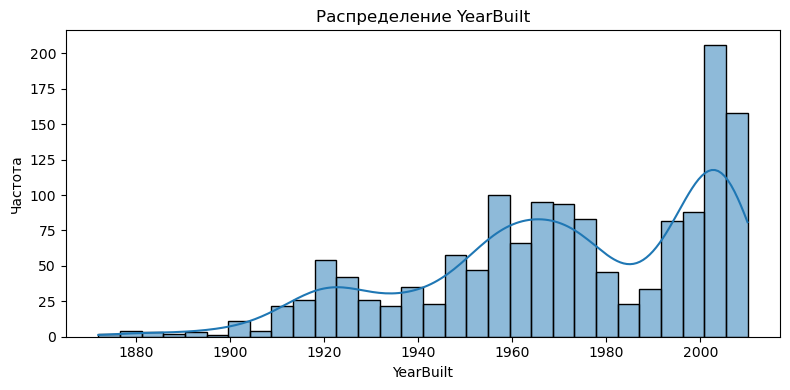

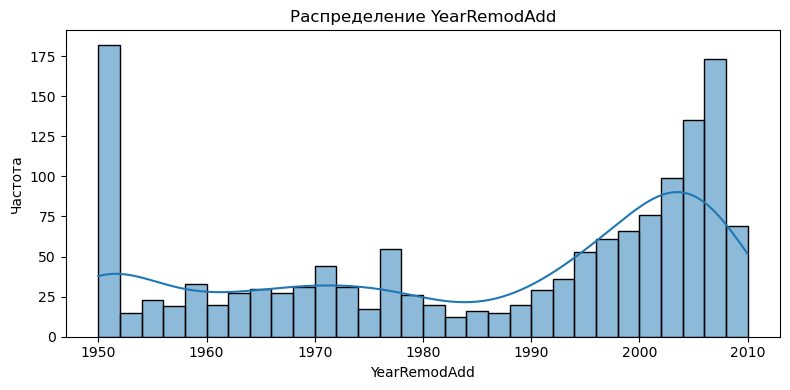

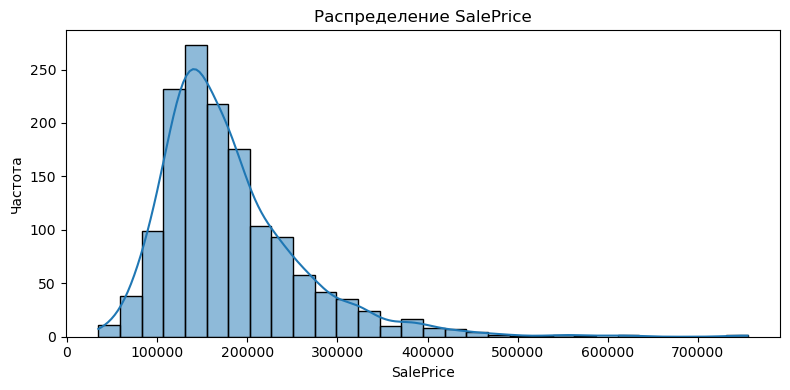

In [41]:
plot_all_numeric_histplot(set2)

- OverallQual и OverallCond — дискретные признаки, хорошо подходят для категориального представления.

- YearBuilt и YearRemodAdd — логично распределены, но есть концентрация старых домов и отдельные дома после 2000-х с явными выбросами.

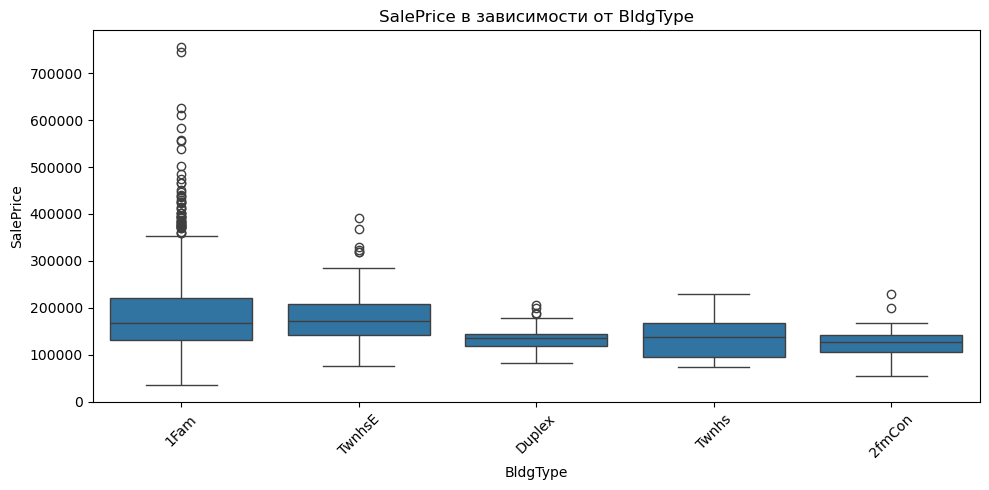

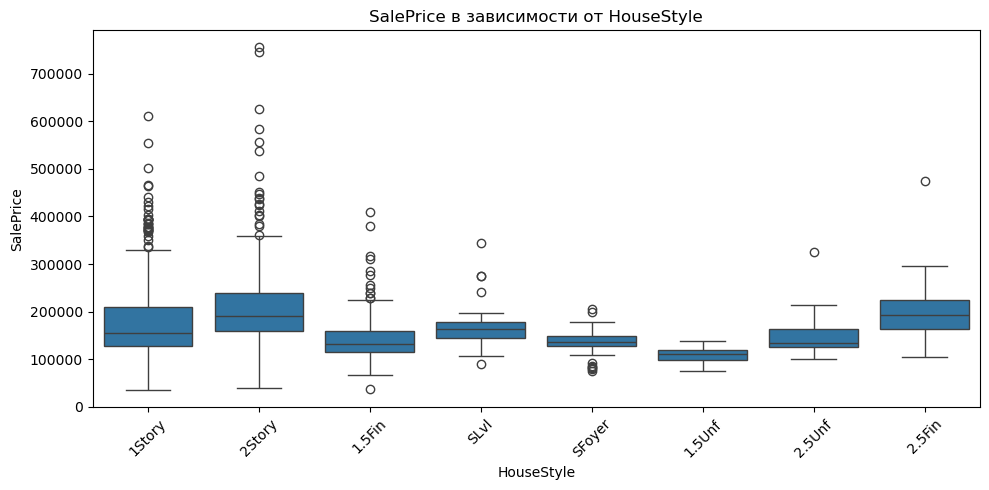

In [42]:
plot_categorical_boxplot(set2)

- В категориях BldgType и HouseStyle наблюдаются сильные выбросы вверх — дома с ценами значительно выше основной группы.

- В одних и тех же типах зданий (1Fam, 2Story) могут встречаться как стандартные, так и очень дорогие дома.

- Индивидуальные дома (1Fam) и двухэтажные (2Story) особенно подвержены разбросу цен — в них часто встречаются элитные дома.

### Set3: Внешний вид и материалы

In [43]:
numeric_correlations(set3)

MasVnrArea    0.477
Name: SalePrice, dtype: float64

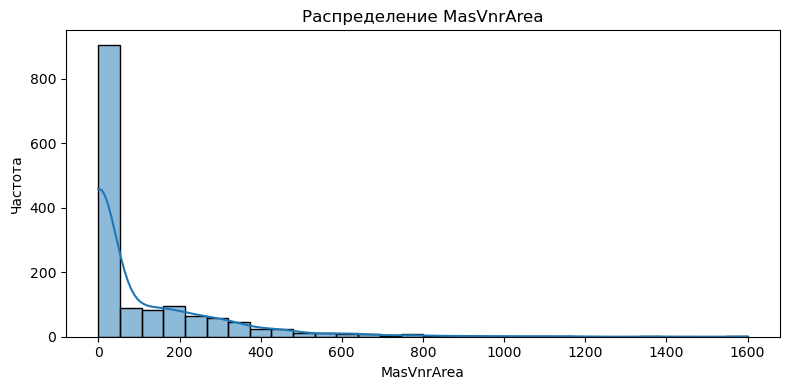

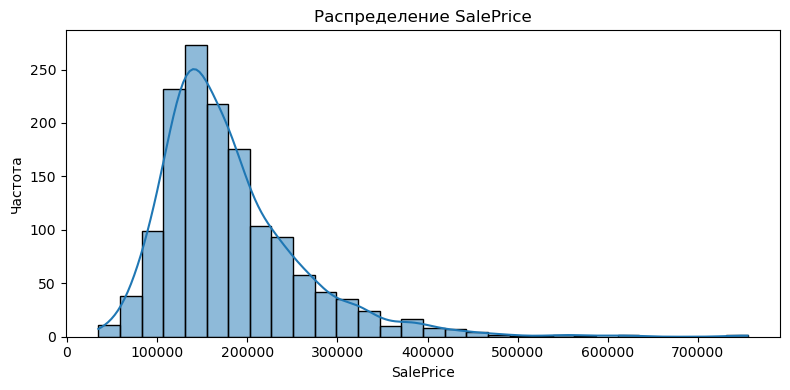

In [44]:
plot_all_numeric_histplot(set3)

- MasVnrArea — сильно скошена: большинство домов имеют нулевую или небольшую отделку.

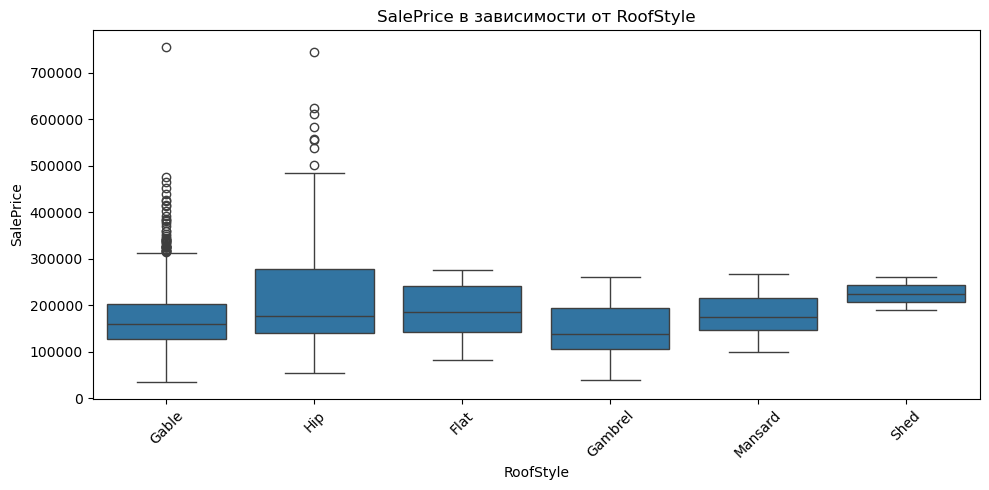

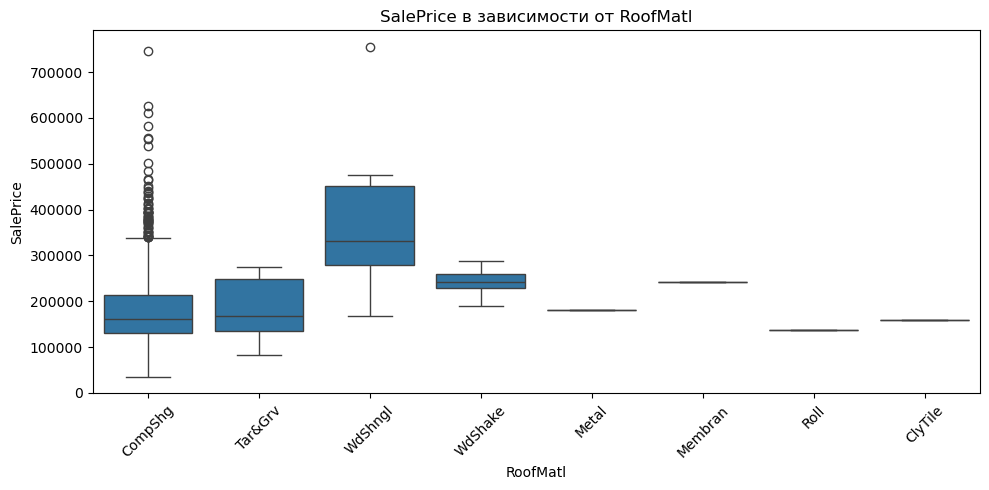

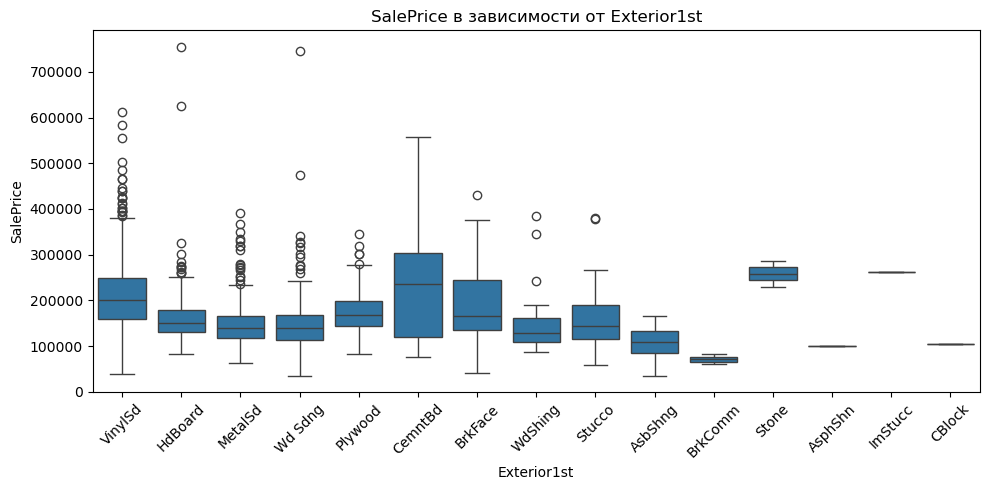

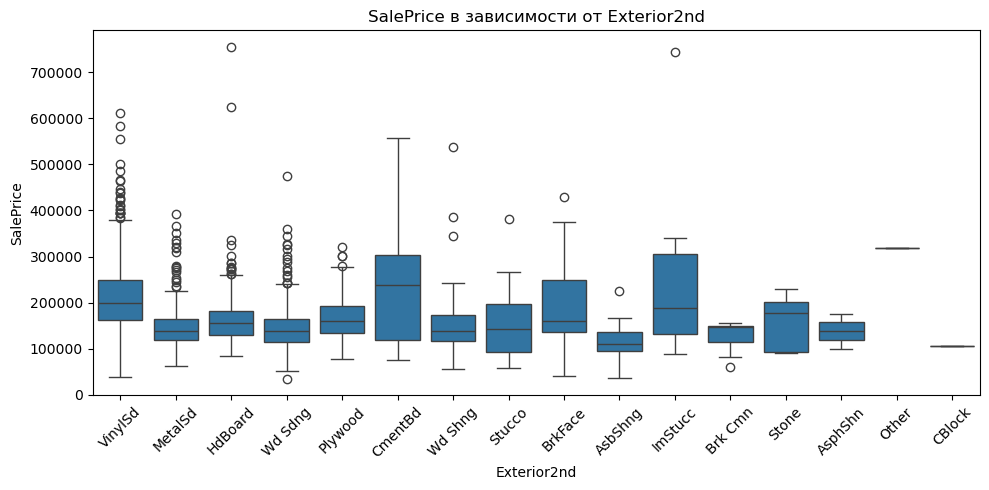

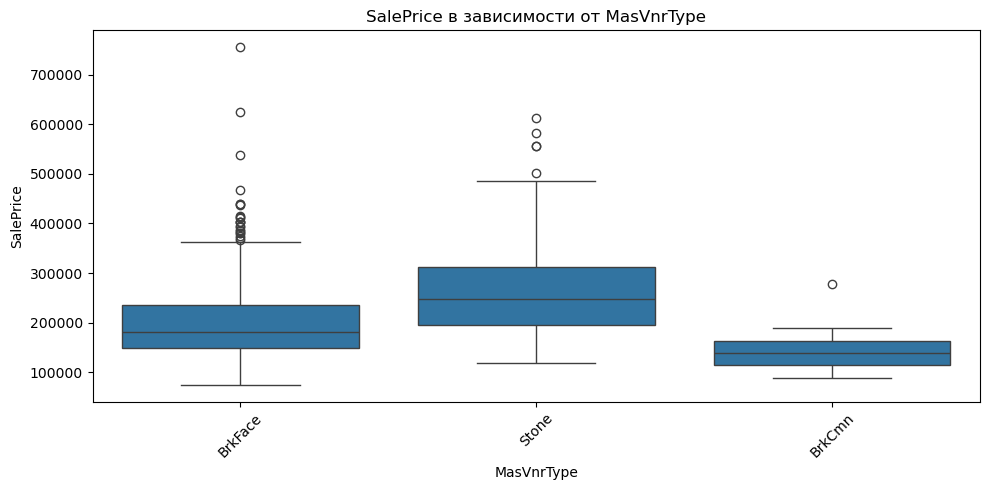

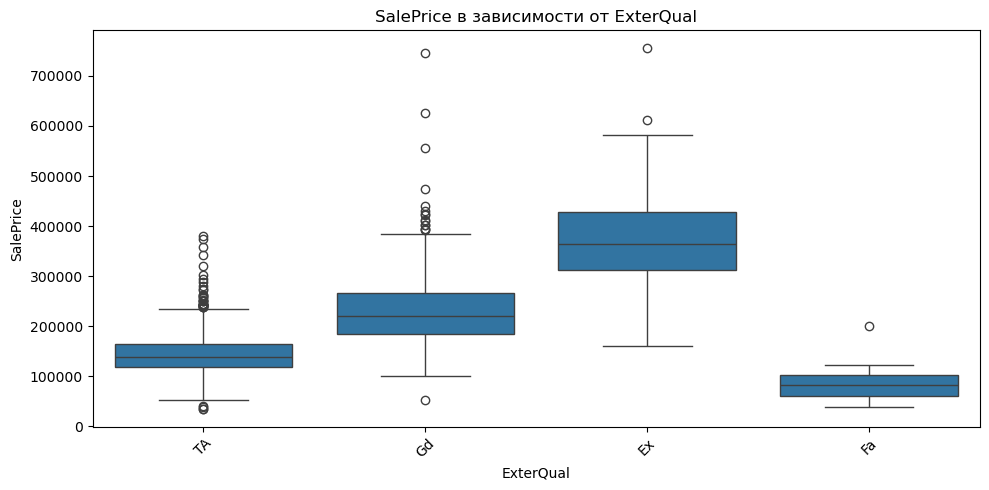

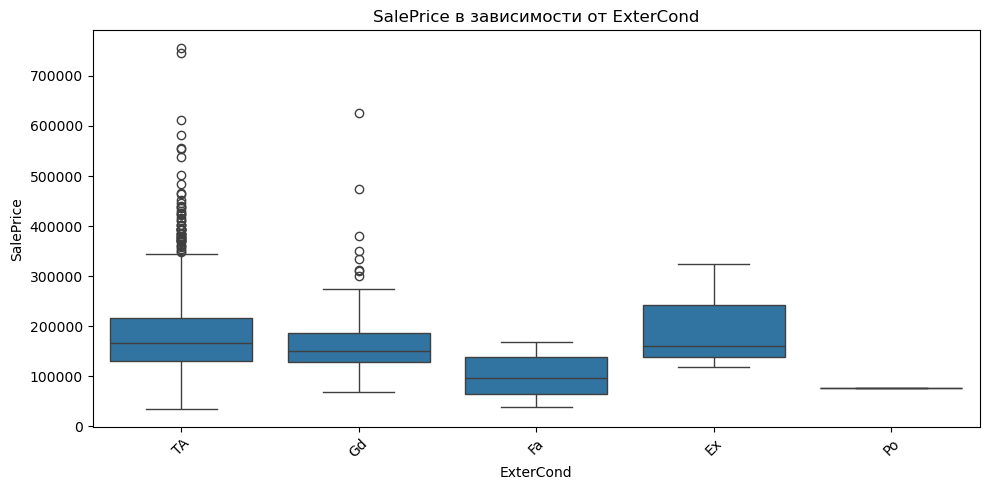

In [45]:
plot_categorical_boxplot(set3)

- В признаках RoofStyle, MasVnrType, Exterior1st/2nd и ExterQual присутствуют ярко выраженные выбросы вверх — это дорогие дома с премиальной отделкой или стилем.

- Отделка фасада (MasVnrType, MasVnrArea) и качество внешней отделки (ExterQual) существенно влияют на цену, но внутри каждой категории могут быть как дешёвые, так и очень дорогие дома.

- Выбросы особенно заметны в категориях Stone, BrkFace, Ex.

### Set4: Фундамент и подвал

In [46]:
numeric_correlations(set4)

TotalBsmtSF    0.614
BsmtFinSF1     0.386
BsmtUnfSF      0.214
BsmtFinSF2    -0.011
Name: SalePrice, dtype: float64

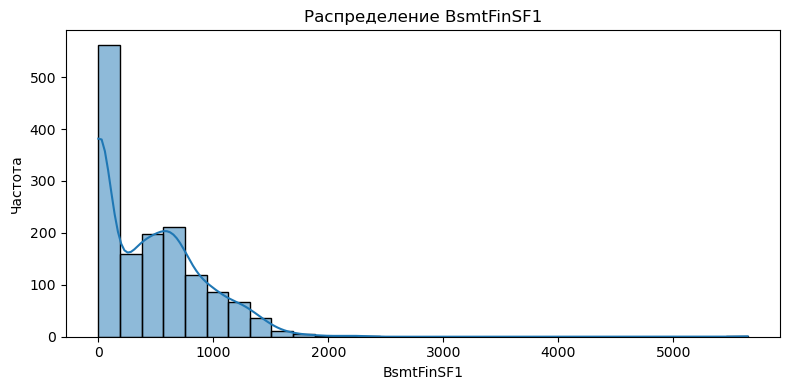

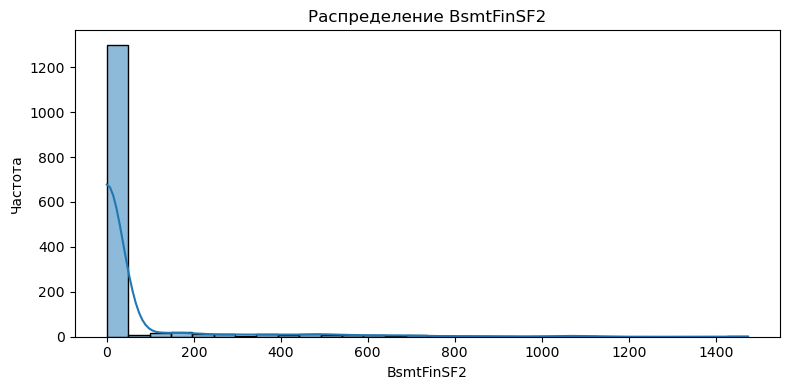

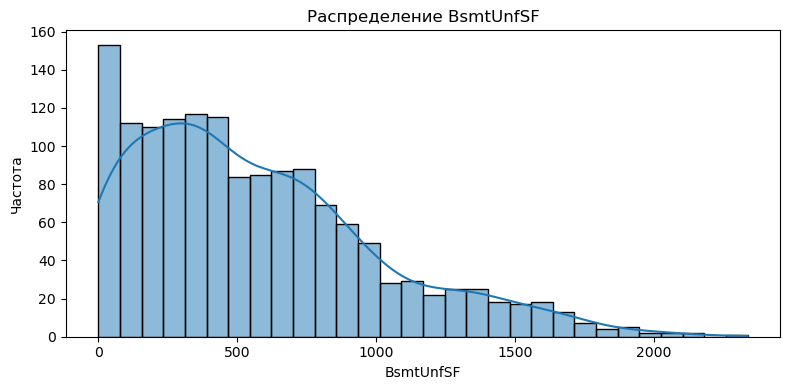

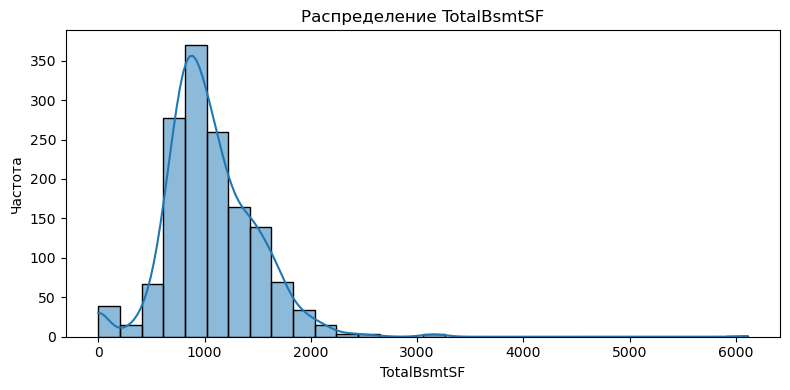

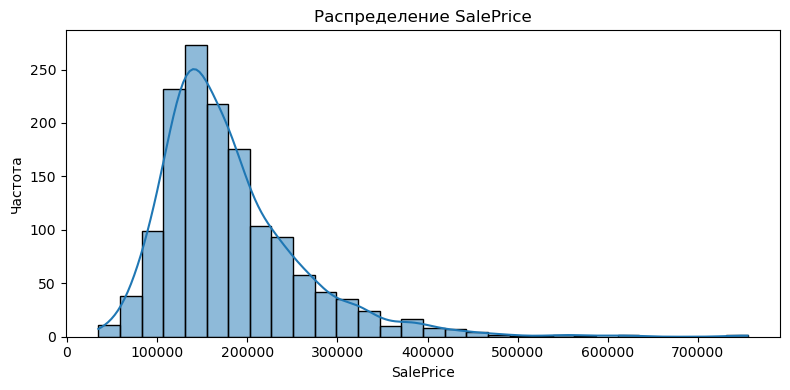

In [47]:
plot_all_numeric_histplot(set4)

- Все числовые признаки сильно перекошены вправо — много домов с маленькими или нулевыми значениями, и несколько с очень большими площадями подвала (выбросы).

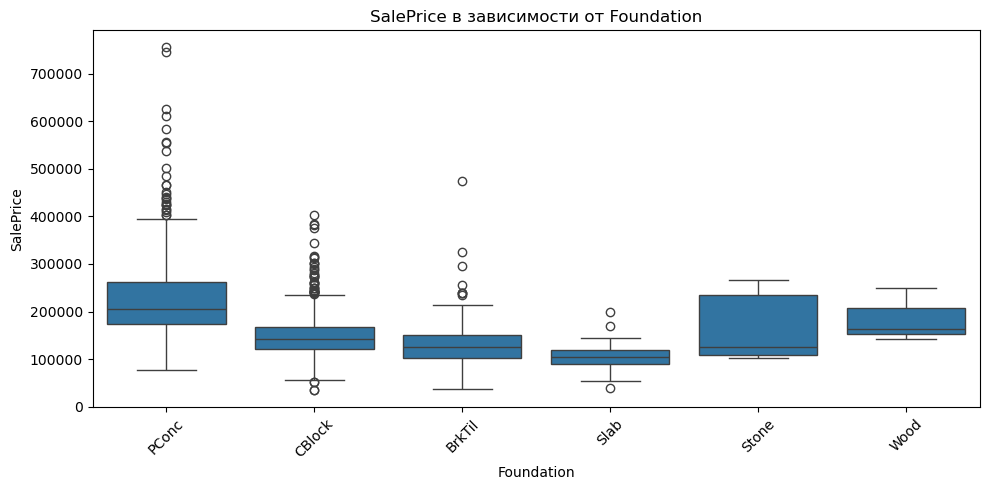

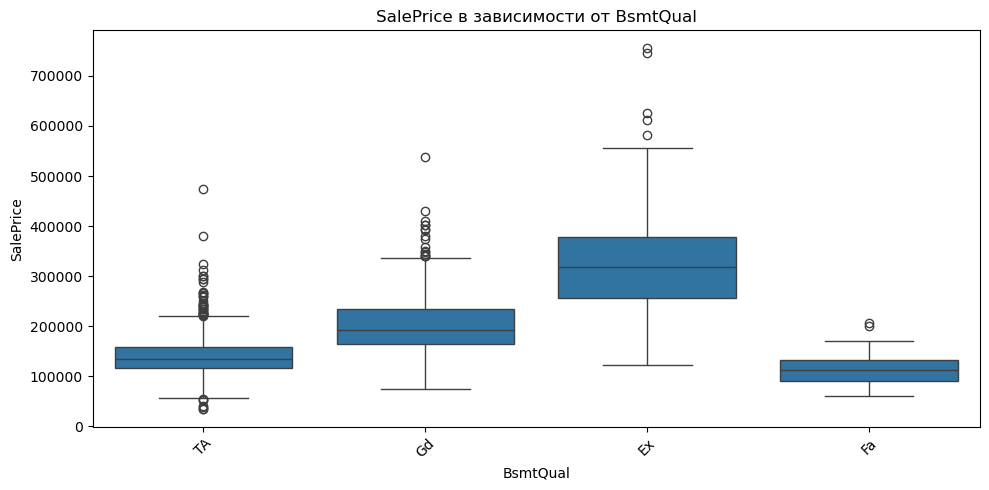

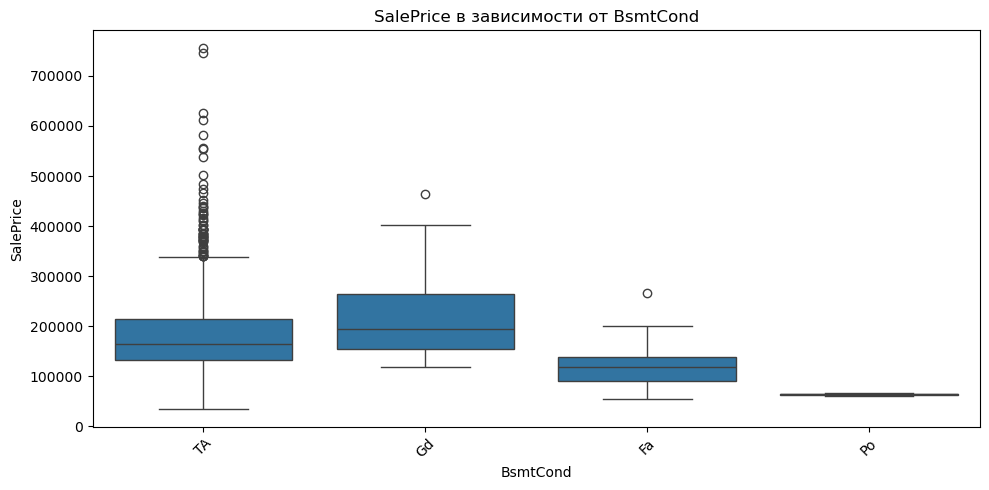

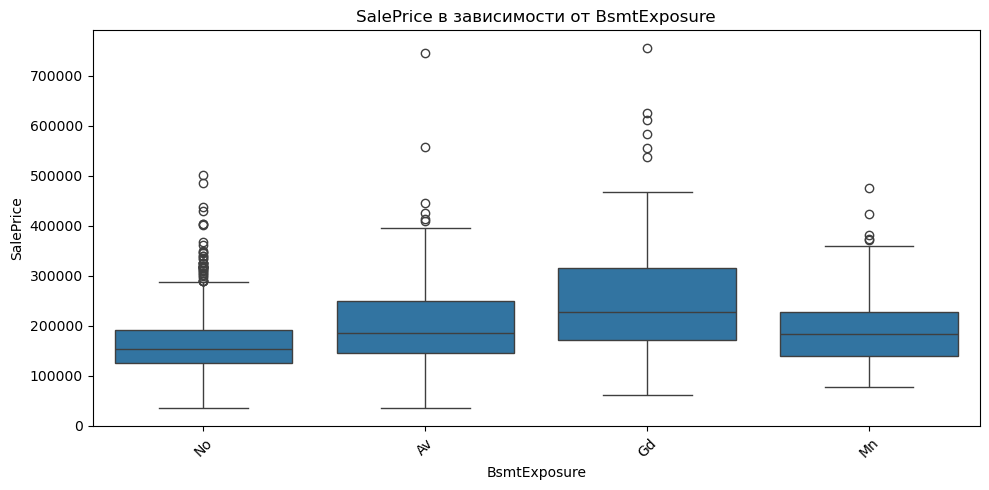

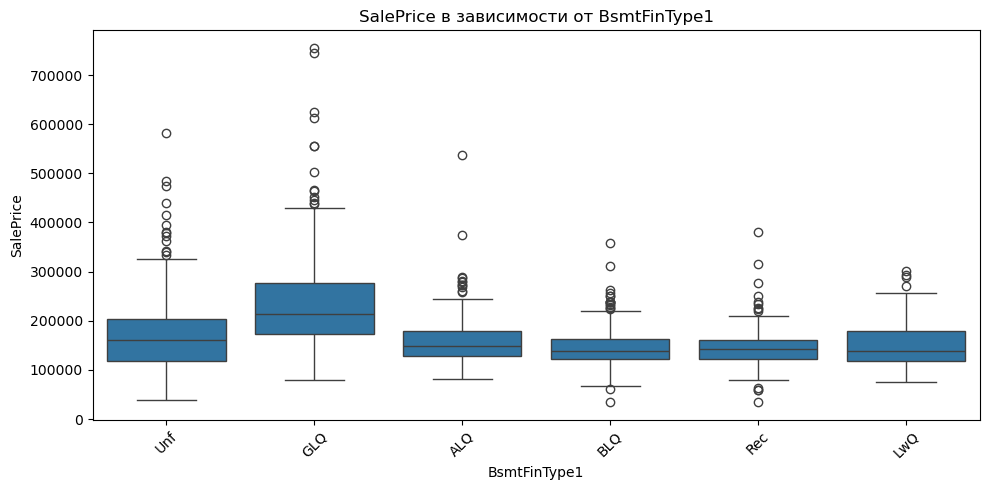

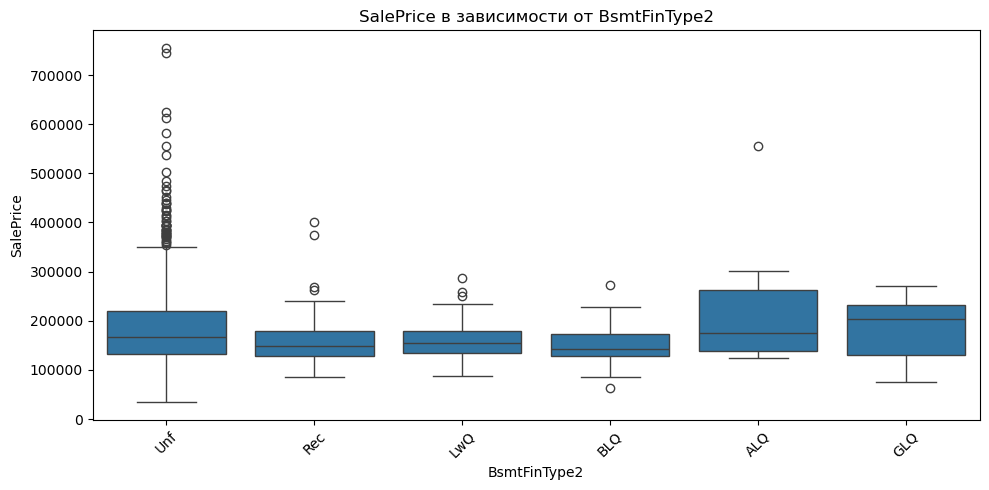

In [48]:
plot_categorical_boxplot(set4)

- Выбросы вверх особенно выражены в признаках BsmtQual, BsmtExposure, Foundation и BsmtFinType1.

- Подвалы высокого качества, с естественным светом и бетонным фундаментом, часто встречаются в дорогих домах, но в этих же категориях бывают и средние дома.

- Выбросы по площади подвала (TotalBsmtSF, BsmtFinSF1) — это элитные дома с огромными подвальными помещениями.

### Set5: Отопление и электроника

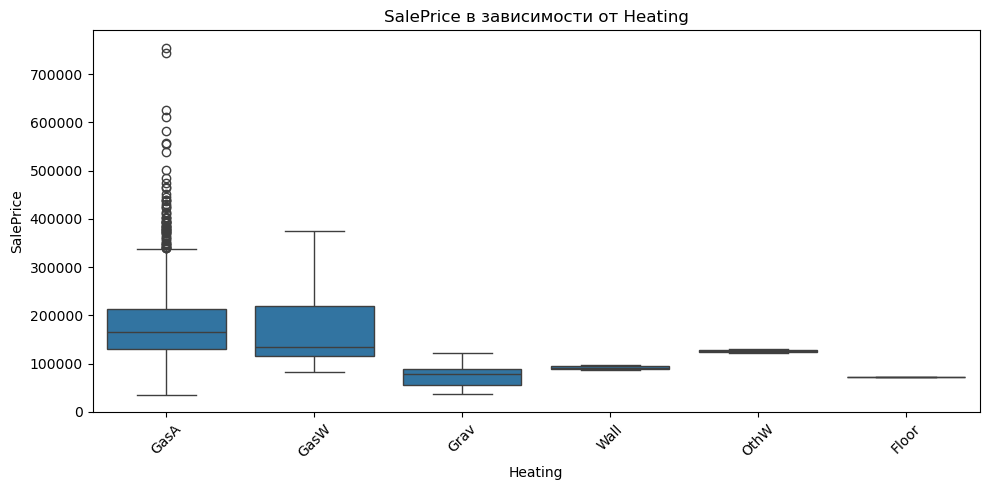

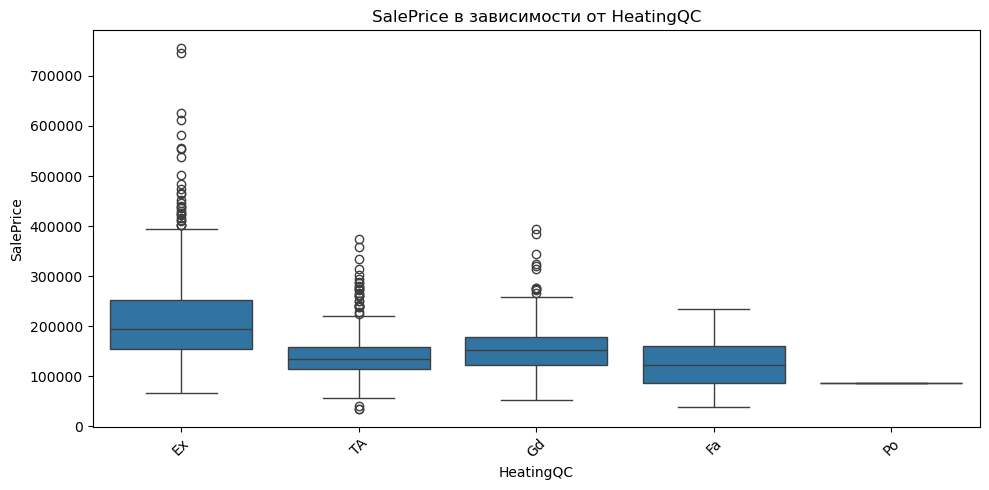

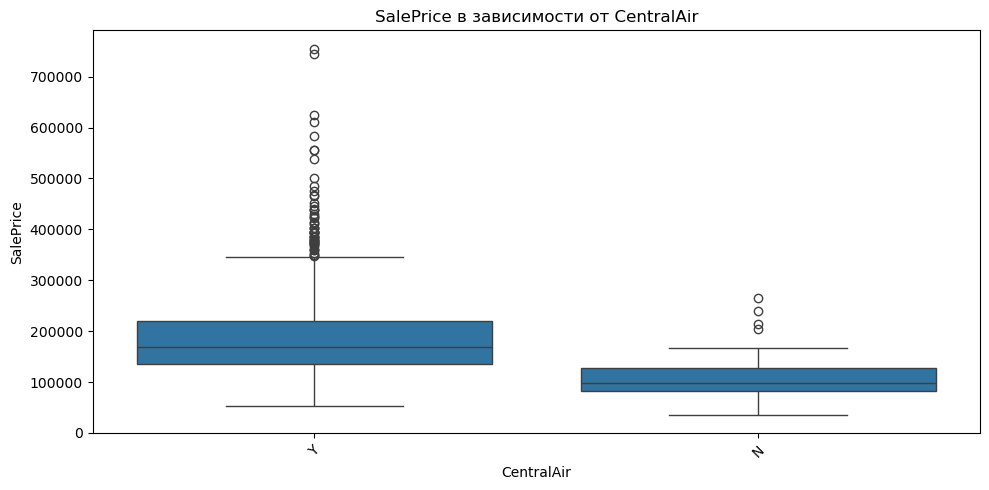

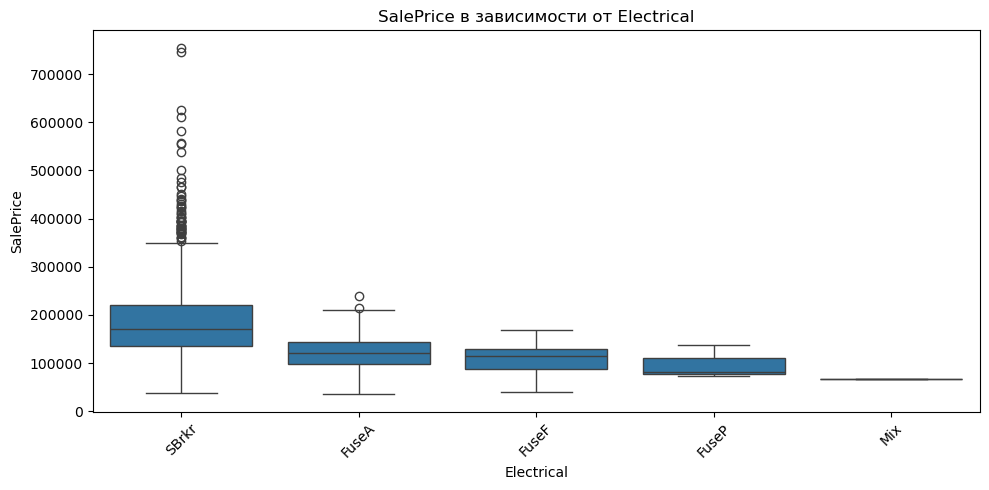

In [51]:
plot_categorical_boxplot(set5)

- Выбросы вверх наблюдаются у признаков HeatingQC, CentralAir, и Electrical.

- Качество отопления (HeatingQC) и наличие центрального кондиционирования (CentralAir) связаны с более дорогими домами, в том числе с выбросами по цене.

- Выбросы в категории SBrkr (электрика) указывают на то, что дорогие дома почти всегда имеют современную проводку.

- Остальные категории встречаются редко и дают мало информации — возможно, их стоит объединить в "другие".

### Set6: Жилая площадь и комнаты

In [52]:
numeric_correlations(set6)

GrLivArea       0.709
1stFlrSF        0.606
FullBath        0.561
TotRmsAbvGrd    0.534
2ndFlrSF        0.319
HalfBath        0.284
BsmtFullBath    0.227
BedroomAbvGr    0.168
BsmtHalfBath   -0.017
LowQualFinSF   -0.026
KitchenAbvGr   -0.136
Name: SalePrice, dtype: float64

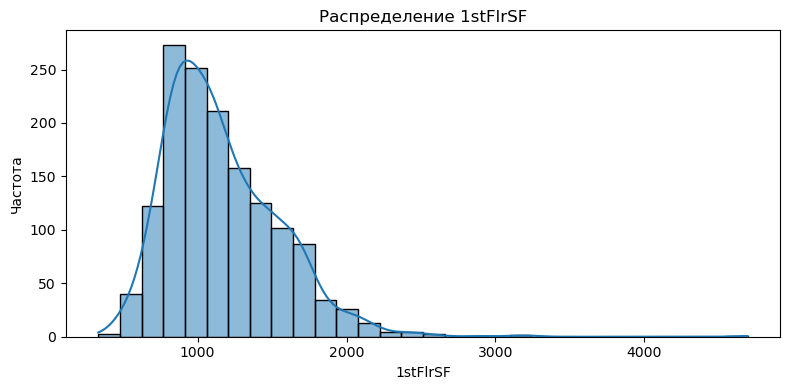

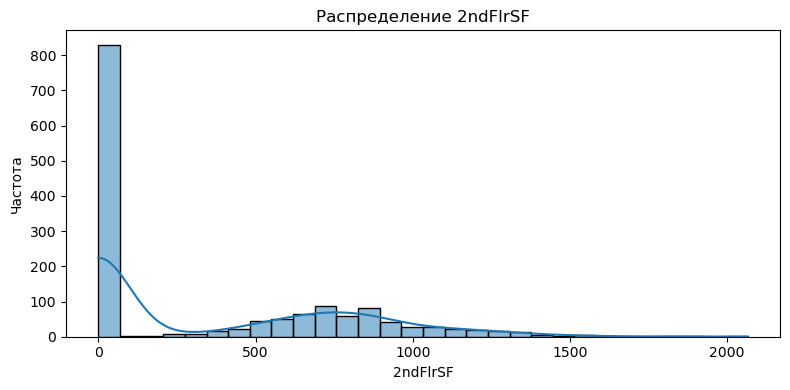

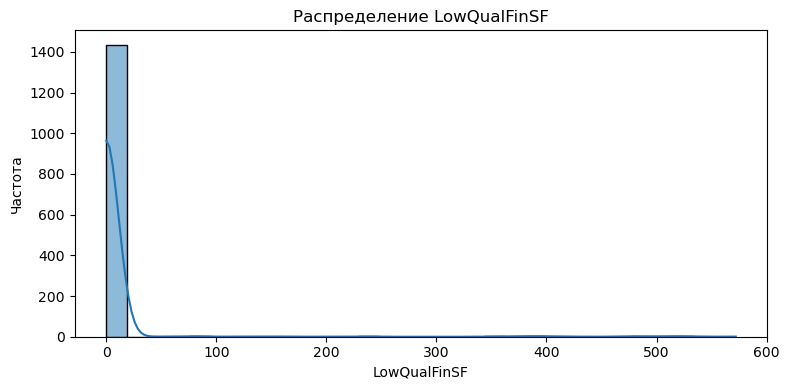

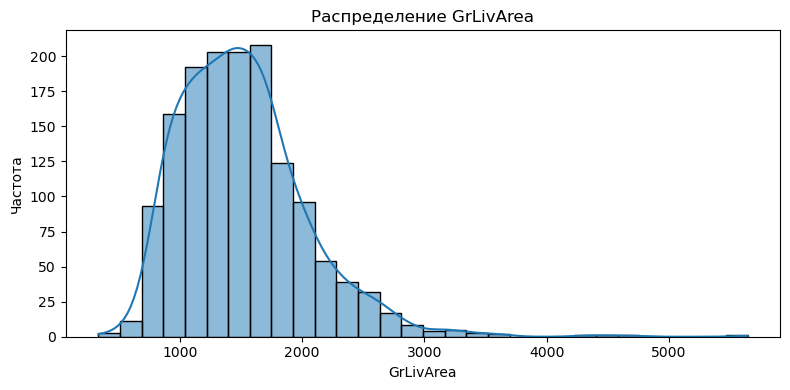

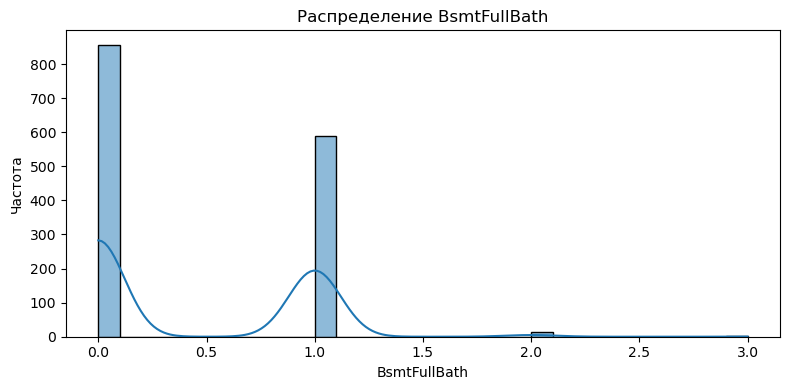

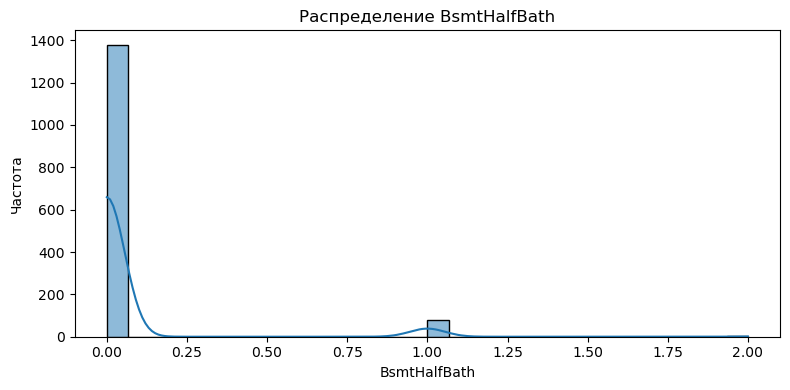

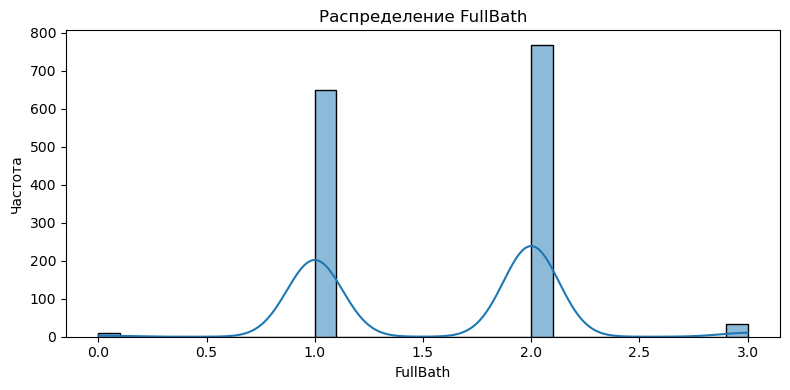

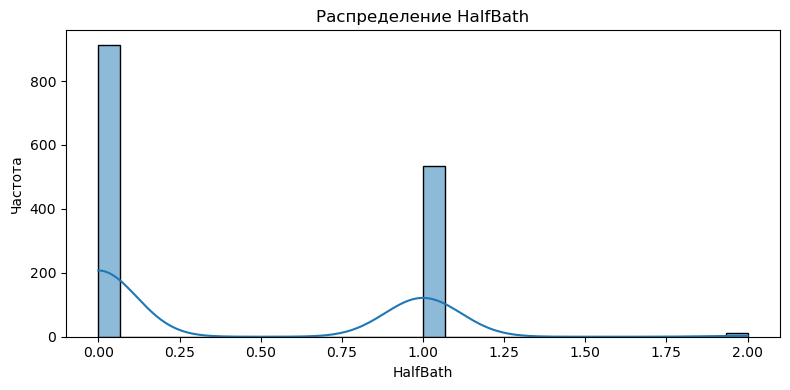

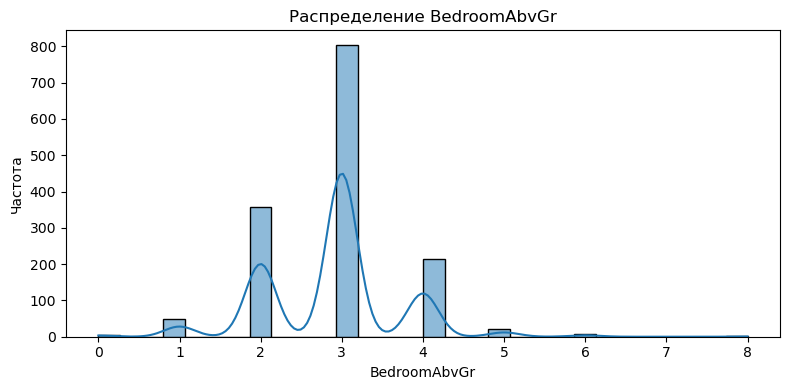

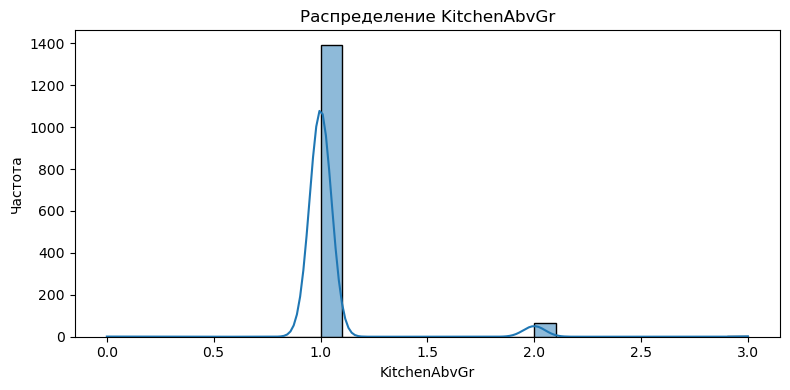

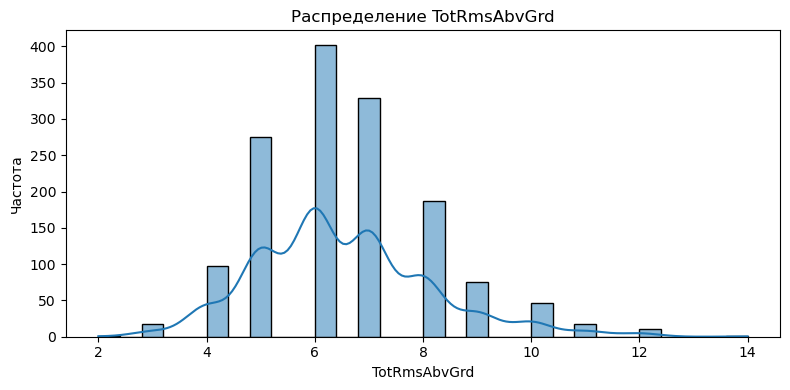

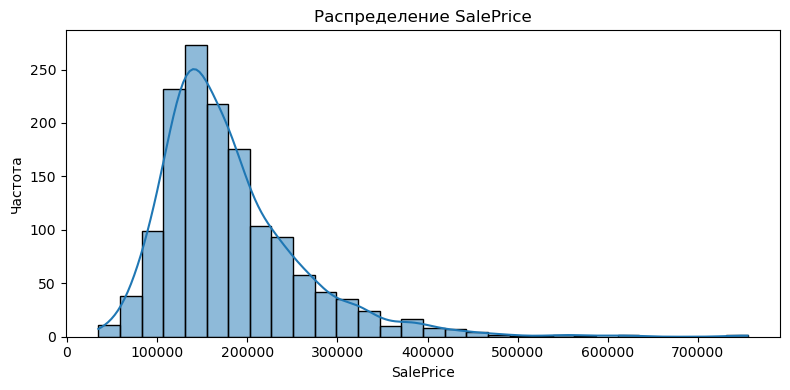

In [53]:
plot_all_numeric_histplot(set6)

- GrLivArea и 1stFlrSF — скошены вправо, есть большие дома - выбросы.

- LowQualFinSF — почти всегда ноль, можно сказать константна.

- KitchenAbvGr, HalfBath и BsmtHalfBath — дискретные признаки.

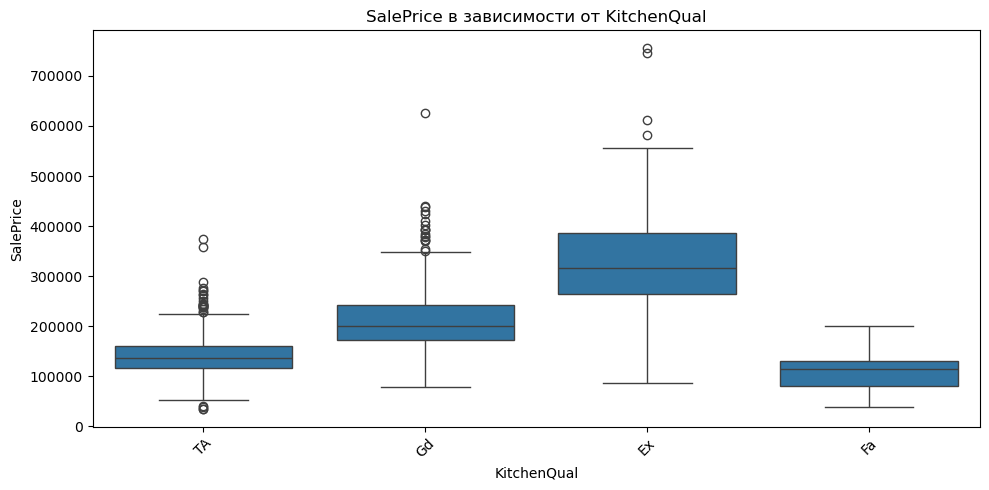

In [54]:
plot_categorical_boxplot(set6)

- Выбросы вверх наиболее выражены у признаков GrLivArea, 1stFlrSF, TotRmsAbvGrd и KitchenQual.


- Большая жилая площадь и высокое качество кухни сильно повышают цену, в том числе создавая очень дорогие дома-выбросы.

- При этом такие выбросы могут исказить восприятие диапазонов, особенно в GrLivArea.

### Set7: Камины и функциональность

In [55]:
numeric_correlations(set7)

Fireplaces    0.467
Name: SalePrice, dtype: float64

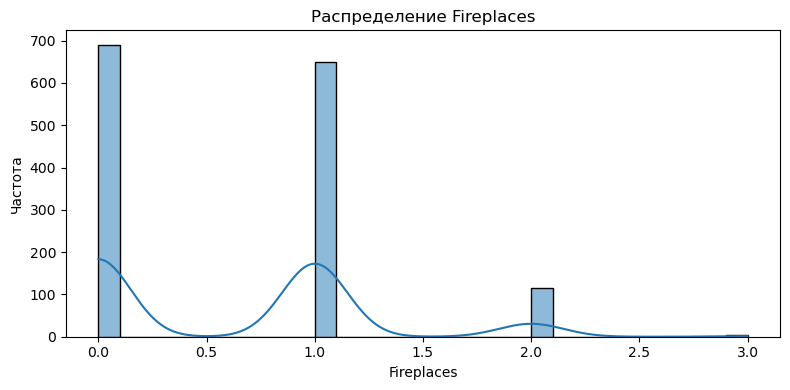

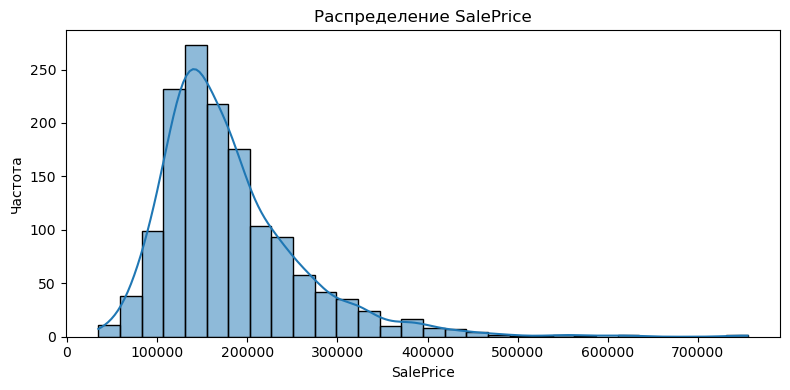

In [56]:
plot_all_numeric_histplot(set7)

- Fireplaces — большинство домов имеют 0 или 1 камин, но встречаются дома с 2+ каминами — возможные выбросы.

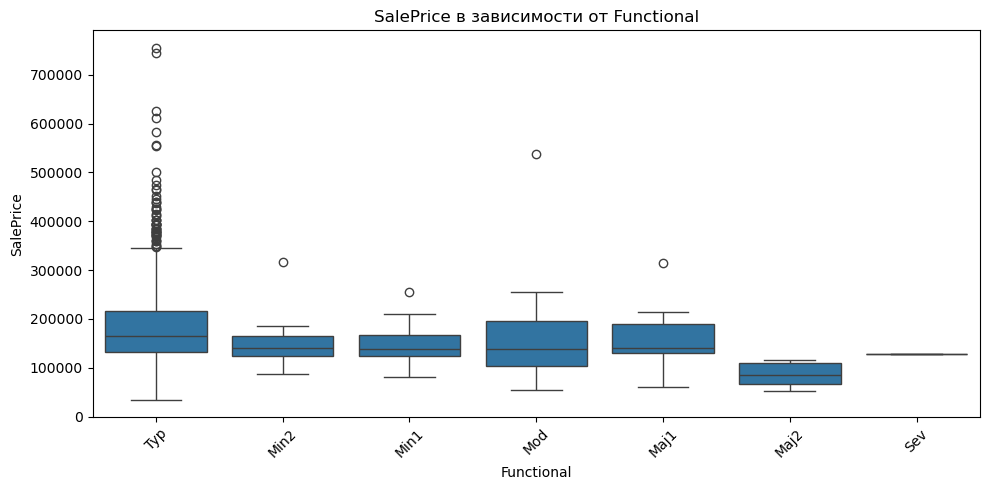

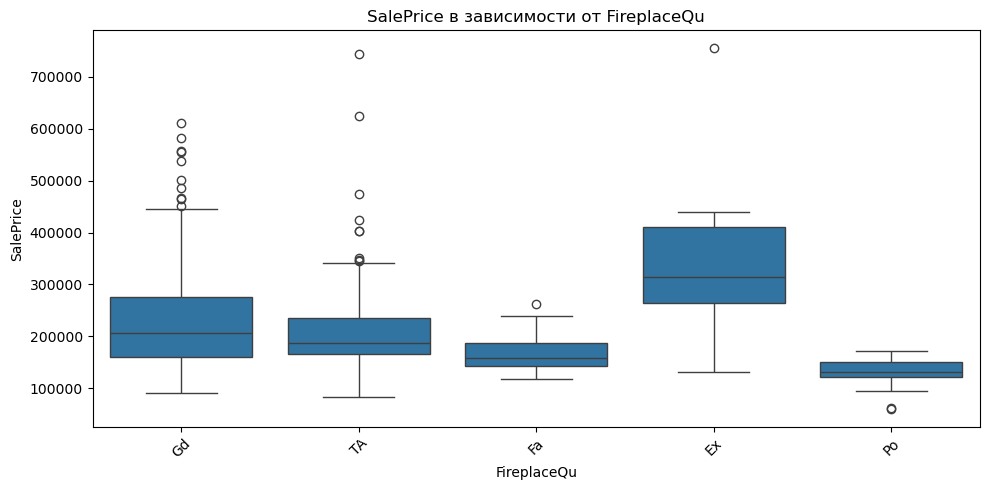

In [57]:
plot_categorical_boxplot(set7)

- Выбросы вверх заметны у признаков Fireplaces, FireplaceQu и Functional.

- Дома с несколькими каминами и качественной отделкой каминов (например, Ex, Gd) часто относятся к более дорогому сегменту.

- Функциональность дома (Functional = Typ) не ограничивает цену — внутри неё встречаются как дешёвые, так и элитные дома.

- Выбросы здесь несут важную информацию — они отражают удобства и восприятие комфорта, которые ценятся на рынке.

### Set8: Гараж

In [58]:
numeric_correlations(set8)

GarageCars     0.640
GarageArea     0.623
GarageYrBlt    0.486
Name: SalePrice, dtype: float64

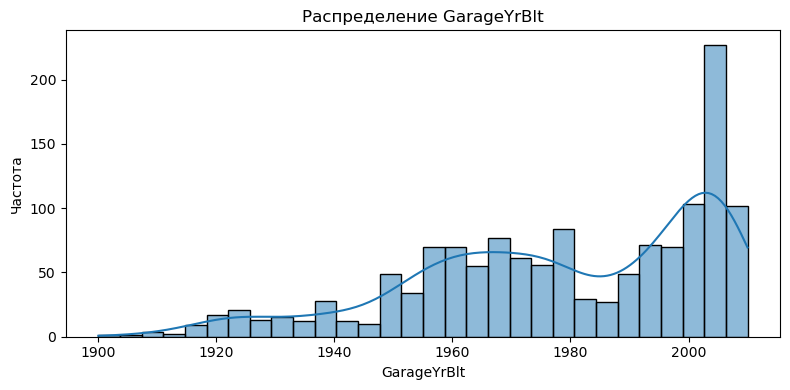

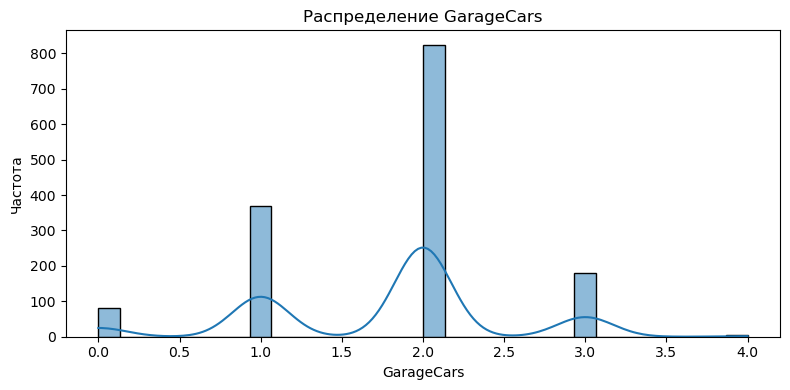

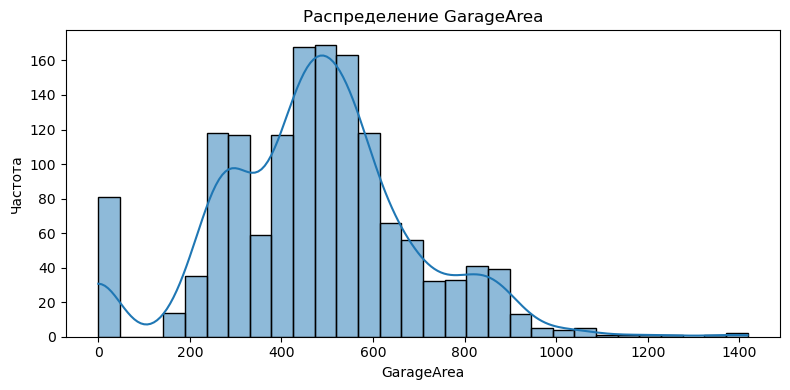

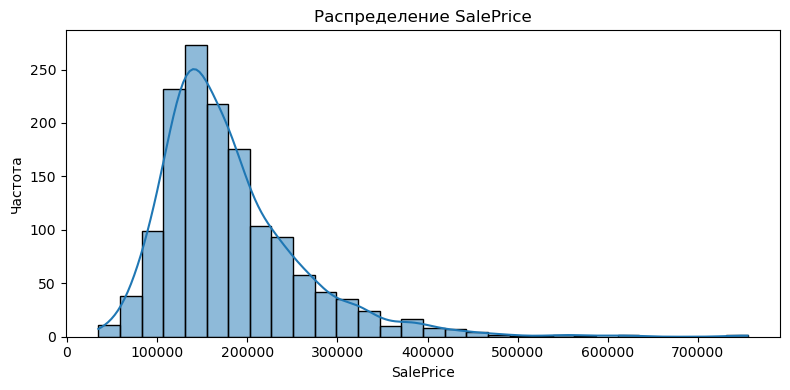

In [59]:
plot_all_numeric_histplot(set8)

- GarageArea и GarageCars — положительно скошены, есть большие значения (гаражи на 4+ машин) — возможные выбросы.

- GarageYrBlt — разброс от начала 2000-х

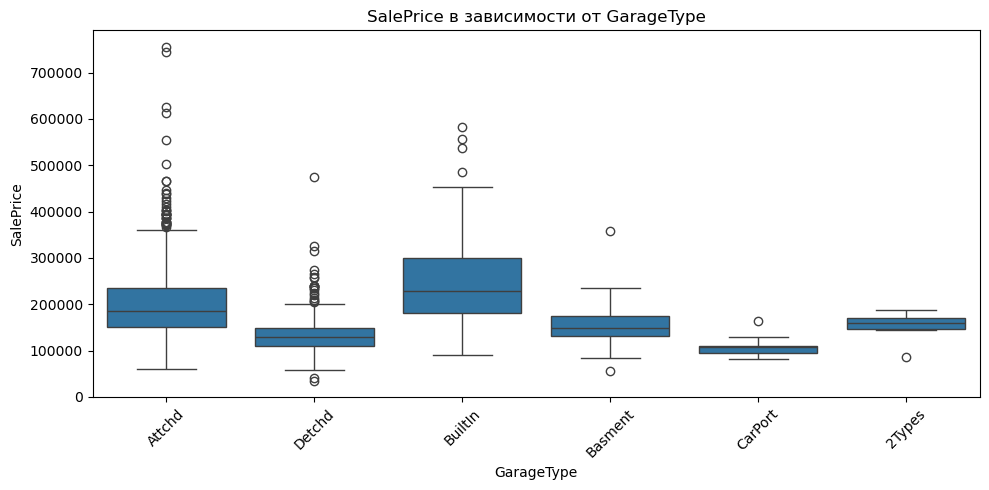

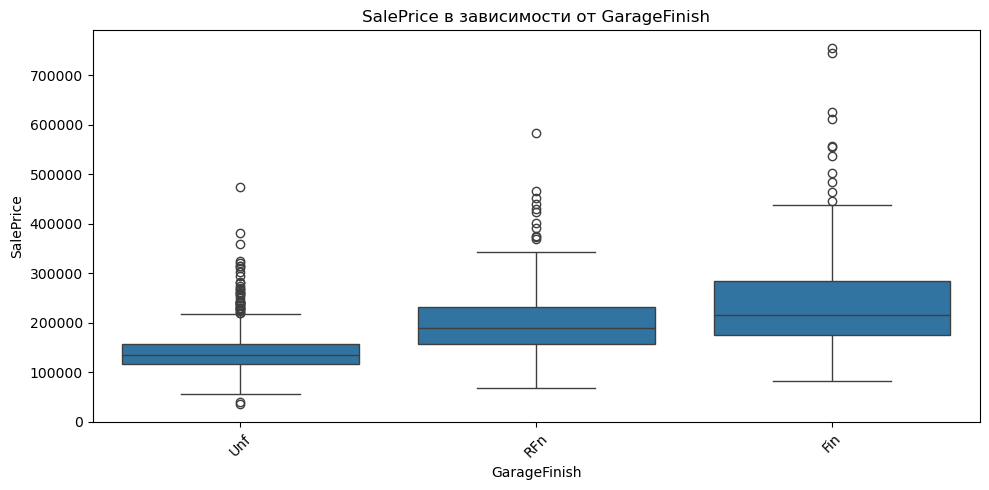

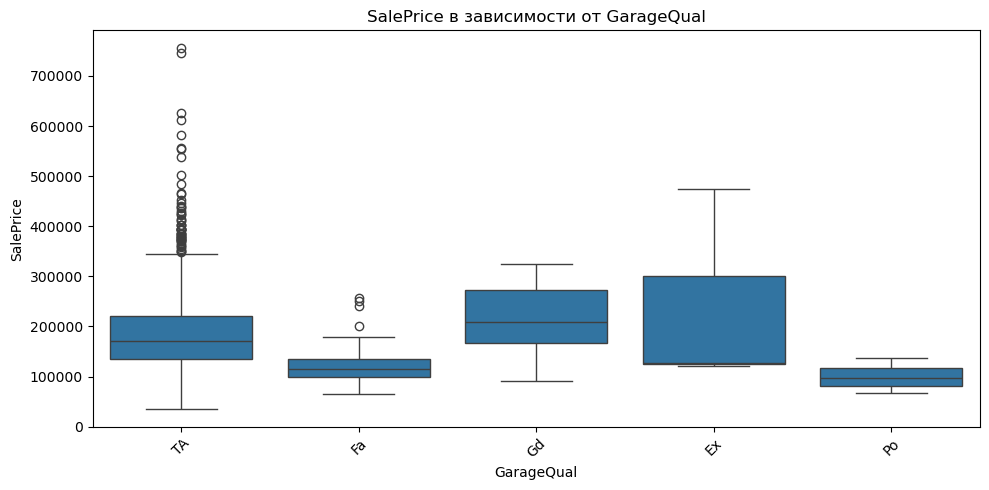

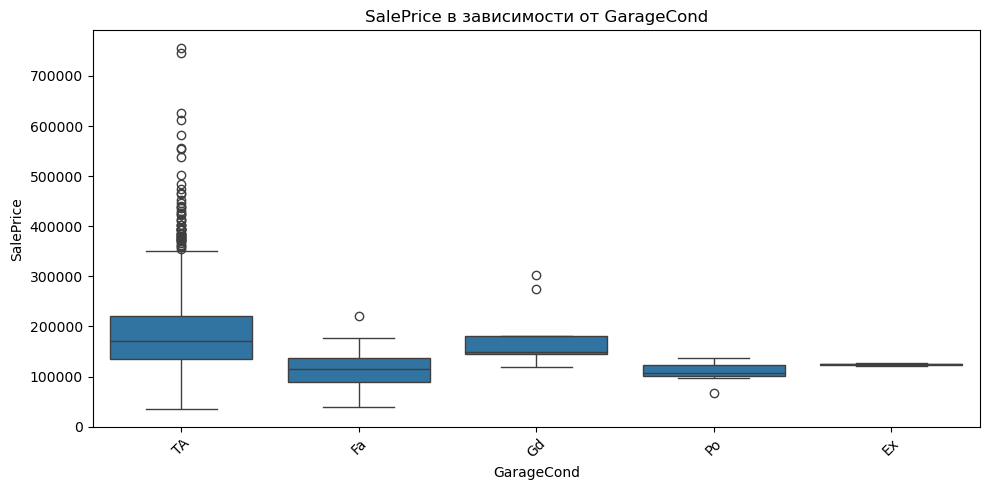

In [60]:
plot_categorical_boxplot(set8)

- Выбросы вверх особенно заметны в признаках GarageType, GarageFinish и GarageArea.

- Крупные, современные, хорошо отделанные гаражи — частый признак дорогого дома, создают выбросы по цене.

- Внутри категорий Attchd, Fin и т.д. могут быть как средние, так и элитные дома — важно не обобщать.

### Set9: Дополнительно

In [61]:
numeric_correlations(set9)

WoodDeckSF       0.324
OpenPorchSF      0.316
ScreenPorch      0.111
3SsnPorch        0.045
MiscVal         -0.021
EnclosedPorch   -0.129
Name: SalePrice, dtype: float64

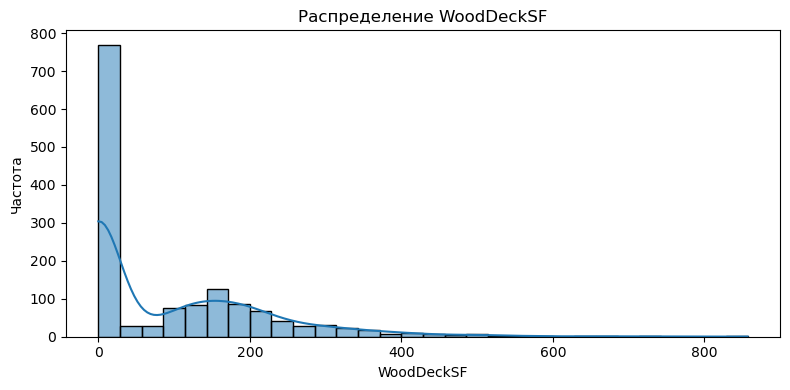

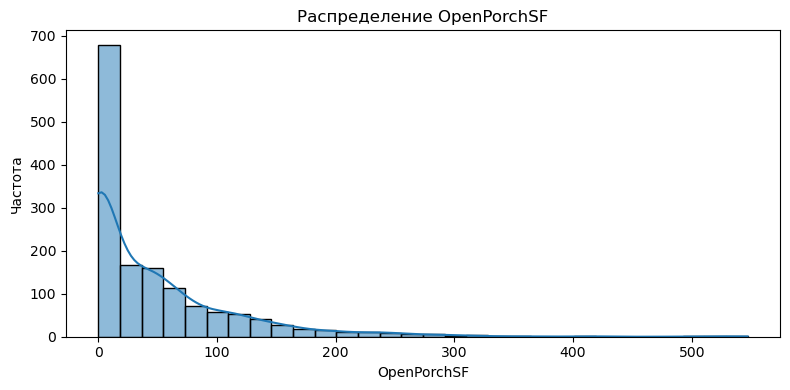

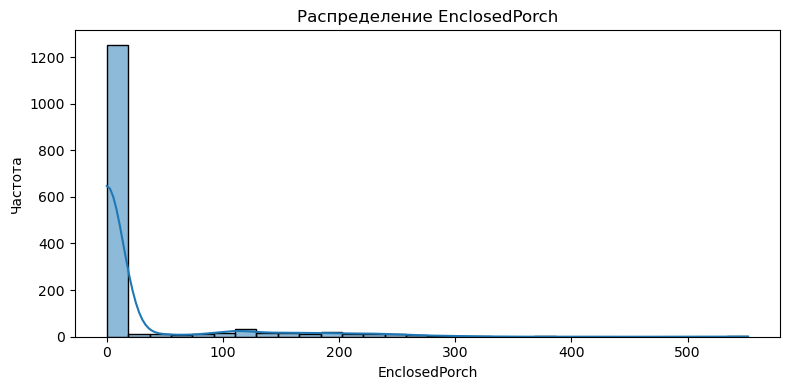

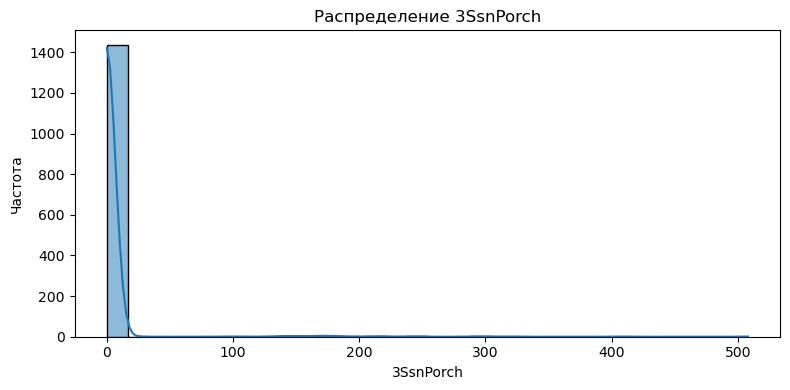

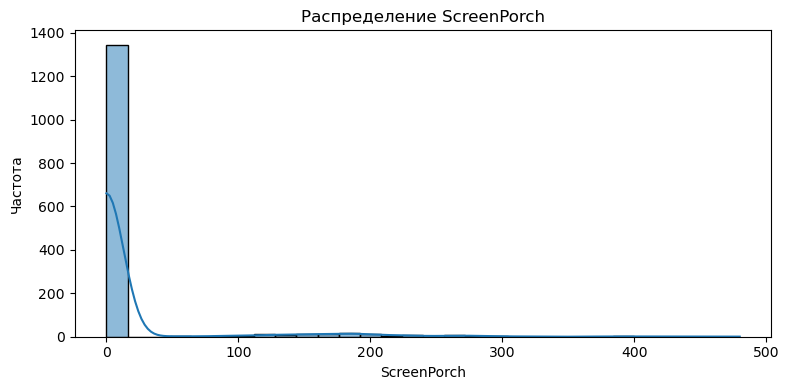

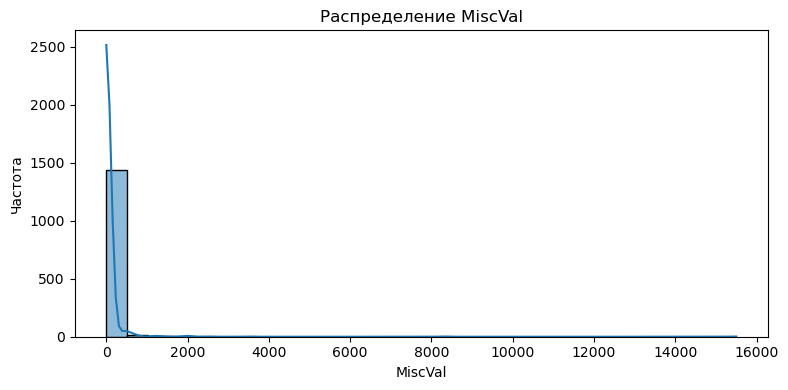

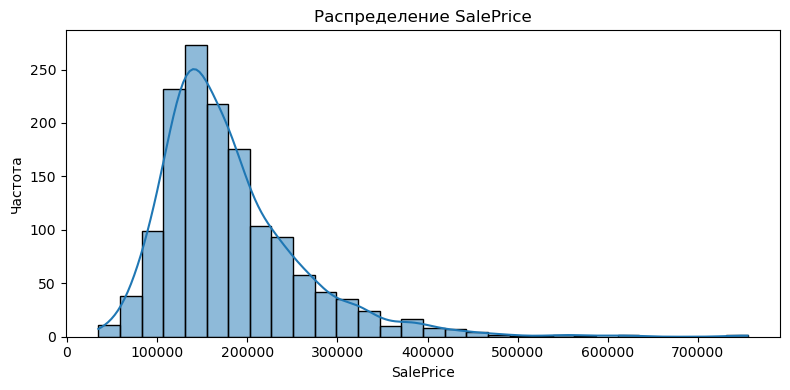

In [62]:
plot_all_numeric_histplot(set9)

- Большинство признаков сильно скошены вправо (много нулей, похожи на константные переменные).

- Выраженные выбросы в WoodDeckSF, OpenPorchSF, MiscVal

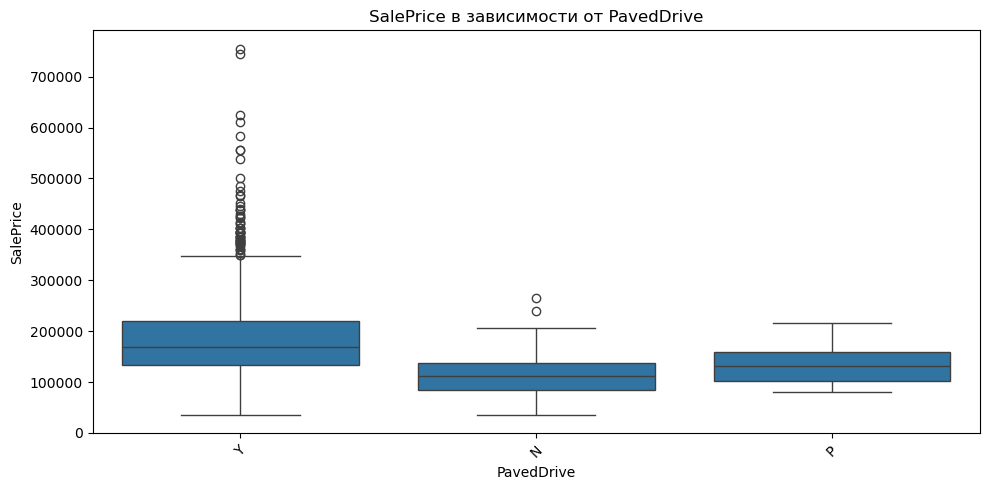

In [67]:
plot_categorical_boxplot(set9)

- Асфальтированный подъезд (PavedDrive = Y) — встречается у домов в высоком ценовом сегменте.

### Set10: Продажа

In [64]:
numeric_correlations(set10)

MoSold    0.046
YrSold   -0.029
Name: SalePrice, dtype: float64

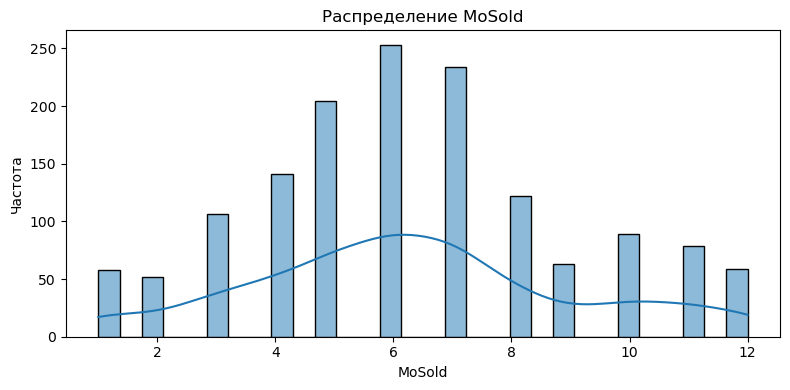

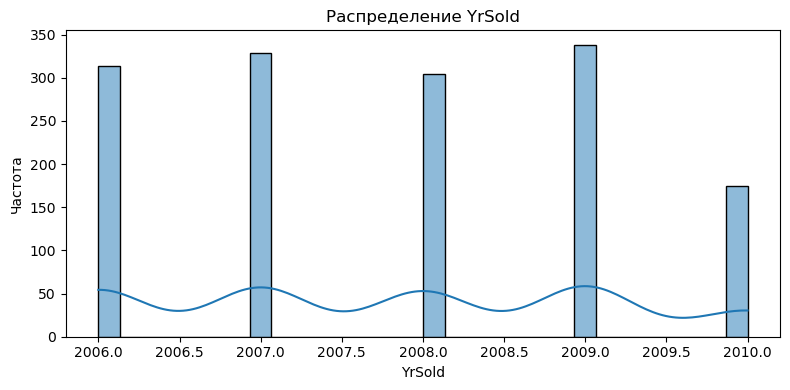

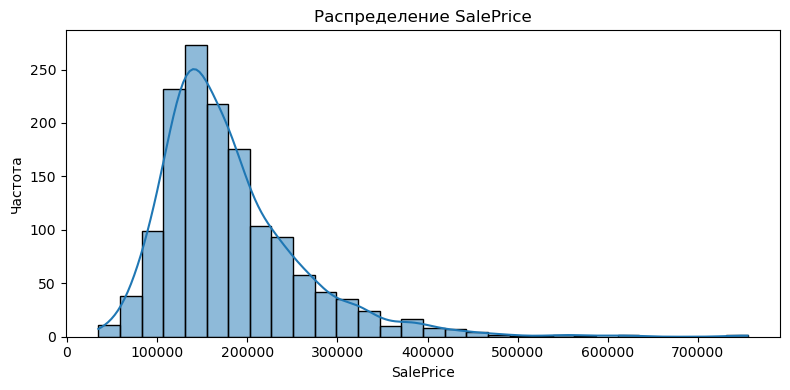

In [65]:
plot_all_numeric_histplot(set10)

- MoSold — равномерное распределение по месяцам, пик летом.

- YrSold — чуть больше продаж в 2009–2010, но без явной динамики цен.

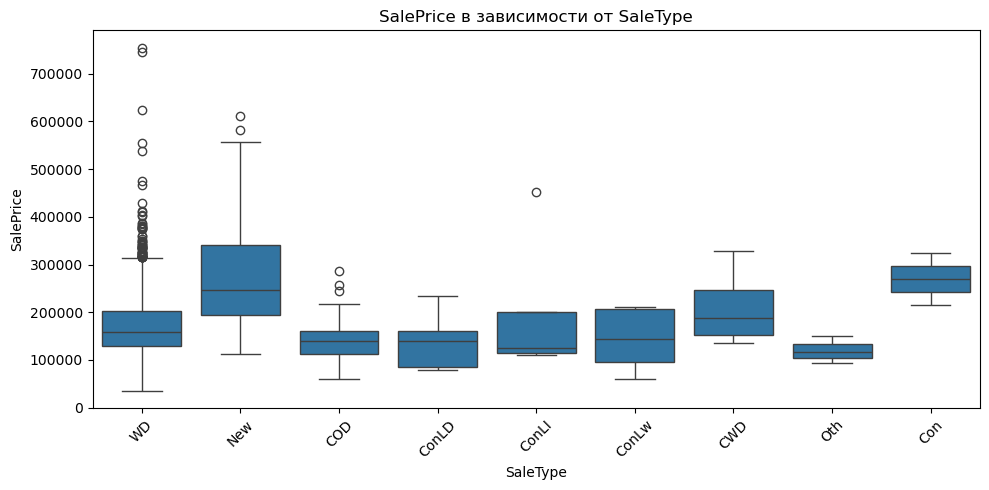

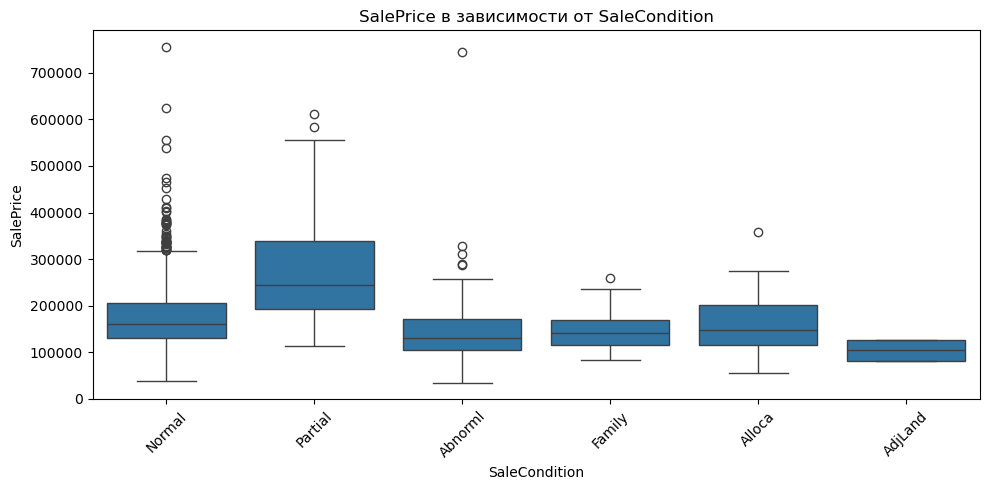

In [66]:
plot_categorical_boxplot(set10)

- Выбросы вверх заметны в категориях SaleType = New / Con и SaleCondition = Partial.

- Новые дома (New) или частичная постройка (Partial) часто входят в рынок по высокой цене — формируют выбросы вверх.

- Большинство обычных продаж (WD, Normal) содержат широкий разброс, и именно в них встречаются дорогие дома.